<a href="https://colab.research.google.com/github/vincent-cinardo/CS301-Project-G5/blob/main/docs/Project_CS301_G5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Vincent Cinardo, Aron Shrestha, Dhyeykumar Kansagara
##Group 5 - Market Genie
##Pantelis Monogioudis
##CS 301 - 104 Introduction to Data Science
##April 4, 2022


###Welcome to our project. We will implement a stock market prediction data science solution using multiple linear regression and batch gradient descent. We will also use JAX, which is a google product developed by DeepMind. Its purpose is to accelerate machine learning processes. Feel free to read the tutorials and follow along with your own stock market data.

---
***Part 1***
---

First we include grad, jit, and vmap from Jax. Jax executes NumPy on GPU, TPU, or CPU if the former two are unavailable. We can use jit to speed up our code. Grad is used for taking derivatives; functionality not built-in native to Python. Vmap is used for the automatic vectorization or batching. We will also be installing kaggle so we can use the data from the project and LinearAlgebra to be used in methods we will use later.

In [ ]:
import math
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import Tuple
from google.colab import files
from jax import grad, jit, vmap
from sklearn.model_selection import train_test_split

# !pip install kaggle
# !pip install LinearAlgebra

Go to www.kaggle.com and click your profile in the top right, then navigate to account. You will see "Create New Api Token". Click that, this will allow this runtime environment to use competition data and datasets from Kaggle.

Upload it and make a temporary kaggle directory to be used For the dataset you will use. Move the json into this new directory; remember to set the permissions on that file for reading and writing.

In [ ]:
from google.colab import files

upload = files.upload();

!mkdir ~/.kaggle/

!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


For our project we will be using stock market data from Alliancebernstein Holding LP. Make a subdirectory to unzip the data into. The commands to download competition data is `kaggle competitions download -c [COMPETITION]`. The command to download data from a kaggle dataset is `kaggle datasets download -d [DATASET]`. We recommend that you keep the same commands here. Add your download and unzipping into the same input directory.

In [ ]:
!kaggle datasets download -d jacksoncrow/stock-market-dataset
!mkdir ./kaggle/
!mkdir ./kaggle/input/

!ls

!unzip -q ./stock-market-dataset.zip -d ./kaggle/input/

100% 520M/522M [00:03<00:00, 194MB/s]
100% 522M/522M [00:03<00:00, 158MB/s]
kaggle	sample_data  stock-market-dataset.zip


Now we have an /input/stocks directory filled with csv files, which are formatted files where each line is a record of data. Reading the csv file into a datagram is easily done with `data = pd.read_csv('./kaggle/input/stocks/AB.csv')`. To reproduce this with your dataset, you must find the proper path to your csv file.

            Date       Open       High        Low      Close  Adj Close  \
0     1988-04-14   0.000000   2.562500   2.500000   2.531250   0.036499   
1     1988-04-15   2.531250   2.593750   2.531250   2.593750   0.037400   
2     1988-04-18   2.593750   2.625000   2.562500   2.593750   0.037400   
3     1988-04-19   2.625000   2.656250   2.625000   2.625000   0.037851   
4     1988-04-20   2.625000   2.656250   2.625000   2.656250   0.038302   
...          ...        ...        ...        ...        ...        ...   
8051  2020-03-26  18.879999  20.700001  18.510000  19.770000  19.770000   
8052  2020-03-27  19.160000  19.610001  18.600000  18.719999  18.719999   
8053  2020-03-30  18.549999  18.870001  17.520000  18.799999  18.799999   
8054  2020-03-31  18.719999  19.170000  18.360001  18.590000  18.590000   
8055  2020-04-01  17.870001  18.129999  16.670000  16.969999  16.969999   

       Volume  
0      471200  
1      430000  
2      376400  
3      364400  
4      317600  
...

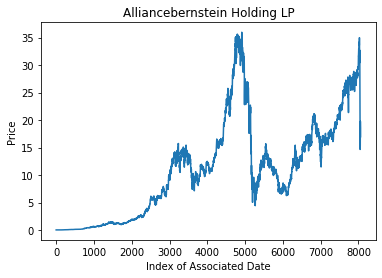

In [ ]:
data = pd.read_csv('./kaggle/input/stocks/AB.csv')
print(data)

plt.title("Alliancebernstein Holding LP")
plt.ylabel("Price")
plt.xlabel("Index of Associated Date")
data["Adj Close"].plot()

In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,8056.000000,8056.000000,8056.000000,8056.000000,8056.000000,8.056000e+03
mean,26.621243,26.972171,26.258371,26.625354,11.045031,2.504598e+05
std,18.921956,19.158822,18.685586,18.935037,9.057975,2.369725e+05
min,0.000000,2.437500,2.406250,2.406250,0.036499,7.600000e+03
25%,12.312500,12.437500,12.178125,12.265000,1.883759,9.940000e+04
50%,24.180000,24.561250,23.875000,24.245000,10.716998,1.859000e+05
75%,32.650002,33.000000,32.157501,32.652501,16.243918,3.185250e+05
max,94.250000,94.940002,93.300003,93.800003,35.963615,3.258200e+06


Before we start implementing our solution, it is important to understand the mathematics behind it.

Simple linear regression describes how an independent variable affects a dependent variable linearly. The equation itself is linear and follows the form: y = mx + b. For comparison, the equation of simple linear regression is y = α + Βx. The slope β and constant α minimize the error within the relationship between x and y. What is meant by error?

When we make a prediction about the values of α and β in our program, more than likely we are quite a bit off. In other words, we have not arrived at the minimum amount of error possible. Assuming we are off, for each point yᵢ = α + βxᵢ + εᵢ, there is some error εᵢ. 

The error can be represented like this:
εᵢ = yᵢ - α - βxᵢ

The error at every value yᵢ is squared, then they are all summed together. To simply sum without squaring would not reflect the error accurately since negative numbers detract from the actual error. We want to accurately represent the total difference between all predictions y from actual values. The goal is to minimize this error ε as much as possible. The process of using ε to find β and α is called the least squares fit. This is achieved by using the correlation between x and y as β. We then take the resulting β, the mean of x, and the mean of y to get the intercept α = ȳ - βx̄. How β and α are found will be explained further.

Correlation is the measure to what extent two variables are linearly related. The equation in is the covariance of x and y, divided by the product of the standard deviation of each respective variable.

β = ∑(x - x̄)(y - ȳ) / σ(x)σ(y)

Now that beta is found, the intercept can be calculated. Remember to find the intercept in a linear equation, y = mx + b → b = y - mx. Here is the equation translated to:

α = ȳ - βx̄

There is a reason the means of x and y are used. Outputs y on average are closer to the mean; a phenomenon known as "regression towards the mean". With each new measurement, there is a tendency to return to the mean. For example, say we measure the performance of baseball players. They might have a great or horrible performance away from the average (extreme value). But with more games, there is a tendency for their performance to return towards the mean. 

Below we define methods to implement the mathetical operations we have discussed.

Covariance: 16318.68720642027
Correlation: 0.7757355451396067
Alpha, Beta: (-1.135339317651903, 0.003023703337579266)


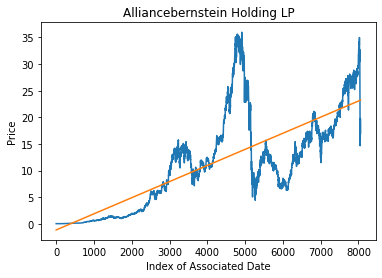

In [ ]:
def predict(alpha, beta, xi):
  return beta * xi + alpha

def mean(x):
  return sum(x) / len(x)

def error(x, y, alpha, beta):
  rval = 0
  for i in range(len(x)):
    rval = rval + (predict(alpha, beta, x[i]) - y[i])**2
  return rval;

def stddev(data):
  mu = mean(data)
  numerator = 0
  for x in data:
    numerator = numerator + (x-mu)**2
  return math.sqrt(numerator / (len(data)-1))

def covar(x, y):
  numerator = 0
  meanx = mean(x)
  meany = mean(y)
  n = len(x)
  for i in range(n):
    numerator = numerator + (x[i] - meanx)*(y[i] - meany)
  return numerator/(n-1)

def corr(x, y):
  stdx = stddev(x)
  stdy = stddev(y)
  if stdx > 0 and stdy > 0:
    return covar(x, y) / (stdx * stdy)
  else:
    return 0

#Least Squares fit
def lsfit(x, y):
  beta = corr(x, y) * stddev(y) / stddev(x)
  alpha = mean(y) - beta * mean(x)
  return alpha, beta

close = data["Adj Close"].to_numpy()
dates = data.index.values
# n = len(data.index)

dates_train, dates_test, close_train, close_test = train_test_split(dates, close, test_size= 0.1, random_state=0)

alpha, beta = lsfit(dates_train, close_train)

line = [predict(alpha,beta,x) for x in dates]

plt.title("Alliancebernstein Holding LP")
plt.ylabel("Price")
plt.xlabel("Index of Associated Date")
plt.plot(dates, close)
plt.plot(dates, line)

print("Covariance: " + str(covar(dates_train, close_train)))
print("Correlation: " + str(corr(dates_train, close_train)))
print("Alpha, Beta: " + str(lsfit(dates_train, close_train)))

In [ ]:
print('Testing dataset error(mean squared error):', error(dates_test, close_test, alpha, beta))

Testing dataset error(mean squared error): 28170.286676167212


---
***Part 2***
---
Jax is a Python library designed for high-performance ML research. Jax is nothing more than a numerical computing library, just like Numpy, but with some key improvements. It was developed by Google and used internally both by Google and Deepmind teams.

Below we use jax to find a fit for our prices. We introduce a new dataset that uses the stock price of Tesla to train our model. We are still using a linear regression model but will be using gradient descent to find a line of fit for our model. 




In [ ]:
dataset = pd.read_csv('./kaggle/input/stocks/TSLA.csv')
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2457.000000,2457.000000,2457.000000,2457.000000,2457.000000,2.457000e+03
mean,194.289007,197.984746,190.499678,194.344526,194.344526,5.829875e+06
std,134.410284,137.644955,131.205551,134.449616,134.449616,5.472882e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.599998,35.150002,33.900002,34.570000,34.570000,1.961500e+06
50%,215.009995,218.449997,210.770004,215.210007,215.210007,4.668200e+06
75%,273.260010,278.000000,268.250000,273.600006,273.600006,7.551200e+06
max,923.500000,968.989990,901.020020,917.419983,917.419983,6.093880e+07


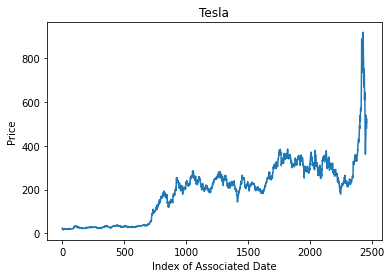

In [ ]:
import jax
import jax.numpy as jnp
import tqdm

y = dataset['Adj Close'].values
x = jnp.array([i for i in range(len(dataset))])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.1, random_state=0)

plt.title("Tesla")
plt.ylabel("Price")
plt.xlabel("Index of Associated Date")
plt.plot(x,y)

Using jax we implement gradient descent to find a fit for our model. 

c*omment-> would be better to explain gradient descent here i think*

Jax has many features to make our runtime efficient. Jax.jit transforms the function which will perform Just In Time (JIT) compilation of a JAX Python function so it can be executed efficiently in XLA.


Gradient descent...
Slope: 0.1592013
y-intercept: 3.8899092e-05


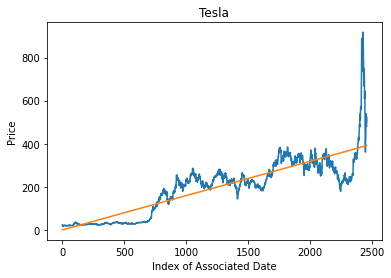

In [ ]:
params = {
    'w': jnp.zeros(x.shape[1:]),
    'b' :0.
}

def forward(params, x):  # predict function
  return jnp.dot(x, params['w']) + params['b']

@jax.jit # speeds up function
def loss_fn(params, x, y):
  err = forward(params, x) - y
  return jnp.mean(jnp.square(err))

grad_fn = jax.grad(loss_fn) # computes derivative of the loss function. takes derivative with respect to the first argument of "loss_fn" i.e params

def gradient_desc(params, x_train, y_train, learn_rate, n_iter=200):
  print('Gradient descent...')
  for _ in range(n_iter):
    loss = loss_fn(params, x_train, y_train)
    # print('Loss: ',loss)
    grads = grad_fn(params, x_train, y_train)
    params['w'] -= learn_rate * grads['w']
    params['b'] -= learn_rate * grads['b']


gradient_desc(params, x_train, y_train, learn_rate=0.0000001)
print('Slope:',params['w'])
print('y-intercept:',params['b'])
line = [forward(params, i) for i in x] 

plt.title("Tesla")
plt.ylabel("Price")
plt.xlabel("Index of Associated Date")
plt.plot(x,y)
plt.plot(x,line)

#This uses gradient descent to form a line

In [ ]:
total_loss = 0 
for sample, ground_truth in zip(x_test, y_test):
  loss = loss_fn(params, sample, ground_truth)
  total_loss += loss

print('Average loss for test dataset:', total_loss/len(x_test))

Average loss for test dataset: 5112.2607


---
***Part 3***
---
Now we use multiple regression to better fit the graph. The first step of multiple regression is to hypothesize. In our data, we hypothesized that the prediction could be modeled as a function of the open, high, low, and volume values. $β_1$, $β_2$, $β_3$, and $β_4$ are their respective parameters of unknown value. $β_0$ is the constant in the equation that we also have to find. So our new hypothesis is y = $β_0$ + $β_1x_1$ + $β_2x_2$ + $β_3x_3$ + $β_4x_4$ + ε

Here we retrieve our xᵢ and y values.

In [ ]:
#Working code, the good stuff. Can probably specify more/less values and test for the experimental part.
import random
from typing import List
import tqdm
#I don't think we need any of this for it to work
"""x1 = data['Open'].values
x2 = data['High'].values
x3 = data['Low'].values
x4 = data['Volume'].values

x = []
for i in range(len(dates)):
  x.append([1, x1[i], x2[i], x3[i], x4[i]])

y = data['Adj Close'].values # this is what we need to predict

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.1, random_state=0)
x_train = jnp.array(x_train)
y_train = jnp.array(y_train)

assert len(x) == len(y)"""

"x1 = data['Open'].values\nx2 = data['High'].values\nx3 = data['Low'].values\nx4 = data['Volume'].values\n\nx = []\nfor i in range(len(dates)):\n  x.append([1, x1[i], x2[i], x3[i], x4[i]])\n\ny = data['Adj Close'].values # this is what we need to predict\n\nx_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.1, random_state=0)\nx_train = jnp.array(x_train)\ny_train = jnp.array(y_train)\n\nassert len(x) == len(y)"

At this point we need to redefine several functions to handle more than one input vector. We need to be able to utilize a scalable number n of inputs, so inputs up to $x_n$. In our case, n = 3.

The functionality of our least squares fit function must change since there are now multiple inputs. Gradient descent will now be used.

Our new prediction will use the dot product xᵀβ. The new error is called mean squared error (MSE). The mean squared error measures the average of each error squared. It can be modeled by the following equation.

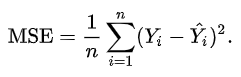

Gradient descent minimizes loss given multiple parameters. Each parameter is given a new value with each gradient step. A gradient step takes the learning rate and a vector of partial derivatives called the gradient. Then, it alters the values of each parameter based on their respective partial derivatives multiplied by the negative learning rate.

In [ ]:
from jax import random

x = dataset[['Open','High', 'Low', 'Volume']].values
y = dataset["Adj Close"].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.1, random_state=0)

print(len(x))
print(len(y))

assert len(x) == len(y)


key = random.PRNGKey(0)

params = {
    'w': random.normal(key,x.shape[1:]),
    'b' :0.
}

print('Randomly initialized beta :', params['w'])

2457
2457
Randomly initialized beta : [ 1.8160863  -0.75488514  0.33988908 -0.53483534]


least squares fit:   0%|          | 1/210 [00:00<00:47,  4.36it/s]

 loss: 15463649000000.0


least squares fit:   1%|          | 2/210 [00:00<00:47,  4.38it/s]

 loss: 12732251000000.0


least squares fit:   1%|▏         | 3/210 [00:00<00:48,  4.29it/s]

 loss: 10483310000000.0


least squares fit:   2%|▏         | 4/210 [00:00<00:48,  4.28it/s]

 loss: 8631603000000.0


least squares fit:   2%|▏         | 5/210 [00:01<00:48,  4.25it/s]

 loss: 7106971300000.0


least squares fit:   3%|▎         | 6/210 [00:01<00:47,  4.32it/s]

 loss: 5851643000000.0


least squares fit:   3%|▎         | 7/210 [00:01<00:46,  4.35it/s]

 loss: 4818046300000.0


least squares fit:   4%|▍         | 8/210 [00:01<00:46,  4.39it/s]

 loss: 3967018600000.0


least squares fit:   4%|▍         | 9/210 [00:02<00:45,  4.39it/s]

 loss: 3266309500000.0


least squares fit:   5%|▍         | 10/210 [00:02<00:45,  4.36it/s]

 loss: 2689369400000.0


least squares fit:   5%|▌         | 11/210 [00:02<00:45,  4.36it/s]

 loss: 2214335600000.0


least squares fit:   6%|▌         | 12/210 [00:02<00:45,  4.40it/s]

 loss: 1823209700000.0


least squares fit:   6%|▌         | 13/210 [00:02<00:44,  4.40it/s]

 loss: 1501168800000.0


least squares fit:   7%|▋         | 14/210 [00:03<00:44,  4.37it/s]

 loss: 1236012000000.0


least squares fit:   7%|▋         | 15/210 [00:03<00:44,  4.41it/s]

 loss: 1017691000000.0


least squares fit:   8%|▊         | 16/210 [00:03<00:44,  4.33it/s]

 loss: 837932700000.0


least squares fit:   8%|▊         | 17/210 [00:03<00:45,  4.26it/s]

 loss: 689926240000.0


least squares fit:   9%|▊         | 18/210 [00:04<00:45,  4.25it/s]

 loss: 568062000000.0


least squares fit:   9%|▉         | 19/210 [00:04<00:44,  4.34it/s]

 loss: 467723160000.0


least squares fit:  10%|▉         | 20/210 [00:04<00:43,  4.39it/s]

 loss: 385107500000.0


least squares fit:  10%|█         | 21/210 [00:04<00:43,  4.35it/s]

 loss: 317084800000.0


least squares fit:  10%|█         | 22/210 [00:05<00:43,  4.32it/s]

 loss: 261076840000.0


least squares fit:  11%|█         | 23/210 [00:05<00:43,  4.27it/s]

 loss: 214962010000.0


least squares fit:  11%|█▏        | 24/210 [00:05<00:43,  4.30it/s]

 loss: 176992600000.0


least squares fit:  12%|█▏        | 25/210 [00:05<00:42,  4.38it/s]

 loss: 145729780000.0


least squares fit:  12%|█▏        | 26/210 [00:05<00:41,  4.39it/s]

 loss: 119988990000.0


least squares fit:  13%|█▎        | 27/210 [00:06<00:41,  4.39it/s]

 loss: 98794910000.0


least squares fit:  13%|█▎        | 28/210 [00:06<00:41,  4.40it/s]

 loss: 81344380000.0


least squares fit:  14%|█▍        | 29/210 [00:06<00:40,  4.44it/s]

 loss: 66976223000.0


least squares fit:  14%|█▍        | 30/210 [00:06<00:41,  4.36it/s]

 loss: 55146010000.0


least squares fit:  15%|█▍        | 31/210 [00:07<00:40,  4.41it/s]

 loss: 45405397000.0


least squares fit:  15%|█▌        | 32/210 [00:07<00:40,  4.41it/s]

 loss: 37385290000.0


least squares fit:  16%|█▌        | 33/210 [00:07<00:40,  4.42it/s]

 loss: 30781805000.0


least squares fit:  16%|█▌        | 34/210 [00:07<00:39,  4.47it/s]

 loss: 25344727000.0


least squares fit:  17%|█▋        | 35/210 [00:08<00:47,  3.66it/s]

 loss: 20867992000.0


least squares fit:  17%|█▋        | 36/210 [00:08<00:52,  3.33it/s]

 loss: 17182013000.0


least squares fit:  18%|█▊        | 37/210 [00:08<00:54,  3.17it/s]

 loss: 14147096000.0


least squares fit:  18%|█▊        | 38/210 [00:09<00:58,  2.95it/s]

 loss: 11648246000.0


least squares fit:  19%|█▊        | 39/210 [00:09<01:05,  2.60it/s]

 loss: 9590776000.0


least squares fit:  19%|█▉        | 40/210 [00:10<01:06,  2.58it/s]

 loss: 7896730000.0


least squares fit:  20%|█▉        | 41/210 [00:10<01:10,  2.41it/s]

 loss: 6501901300.0


least squares fit:  20%|██        | 42/210 [00:11<01:16,  2.20it/s]

 loss: 5353445400.0


least squares fit:  20%|██        | 43/210 [00:11<01:16,  2.19it/s]

 loss: 4407849500.0


least squares fit:  21%|██        | 44/210 [00:12<01:12,  2.30it/s]

 loss: 3629277200.0


least squares fit:  21%|██▏       | 45/210 [00:12<01:18,  2.11it/s]

 loss: 2988228400.0


least squares fit:  22%|██▏       | 46/210 [00:13<01:18,  2.10it/s]

 loss: 2460410400.0


least squares fit:  22%|██▏       | 47/210 [00:13<01:16,  2.13it/s]

 loss: 2025818900.0


least squares fit:  23%|██▎       | 48/210 [00:13<01:13,  2.22it/s]

 loss: 1667992700.0


least squares fit:  23%|██▎       | 49/210 [00:14<01:13,  2.20it/s]

 loss: 1373370200.0


least squares fit:  24%|██▍       | 50/210 [00:15<01:21,  1.95it/s]

 loss: 1130787000.0


least squares fit:  24%|██▍       | 51/210 [00:15<01:20,  1.98it/s]

 loss: 931053100.0


least squares fit:  25%|██▍       | 52/210 [00:16<01:22,  1.91it/s]

 loss: 766599200.0


least squares fit:  25%|██▌       | 53/210 [00:16<01:14,  2.10it/s]

 loss: 631193300.0


least squares fit:  26%|██▌       | 54/210 [00:16<01:08,  2.29it/s]

 loss: 519704640.0


least squares fit:  26%|██▌       | 55/210 [00:17<01:06,  2.32it/s]

 loss: 427908580.0


least squares fit:  27%|██▋       | 56/210 [00:17<01:09,  2.23it/s]

 loss: 352326600.0


least squares fit:  27%|██▋       | 57/210 [00:18<01:09,  2.19it/s]

 loss: 290094900.0


least squares fit:  28%|██▊       | 58/210 [00:18<01:14,  2.05it/s]

 loss: 238855420.0


least squares fit:  28%|██▊       | 59/210 [00:19<01:07,  2.23it/s]

 loss: 196666270.0


least squares fit:  29%|██▊       | 60/210 [00:19<01:05,  2.30it/s]

 loss: 161929090.0


least squares fit:  29%|██▉       | 61/210 [00:19<01:04,  2.30it/s]

 loss: 133327790.0


least squares fit:  30%|██▉       | 62/210 [00:20<01:10,  2.09it/s]

 loss: 109778370.0


least squares fit:  30%|███       | 63/210 [00:21<01:10,  2.07it/s]

 loss: 90388550.0


least squares fit:  30%|███       | 64/210 [00:21<01:05,  2.21it/s]

 loss: 74423580.0


least squares fit:  31%|███       | 65/210 [00:21<01:05,  2.21it/s]

 loss: 61278536.0


least squares fit:  31%|███▏      | 66/210 [00:22<01:06,  2.16it/s]

 loss: 50455370.0


least squares fit:  32%|███▏      | 67/210 [00:22<01:10,  2.03it/s]

 loss: 41543944.0


least squares fit:  32%|███▏      | 68/210 [00:23<01:12,  1.96it/s]

 loss: 34206572.0


least squares fit:  33%|███▎      | 69/210 [00:24<01:14,  1.89it/s]

 loss: 28165192.0


least squares fit:  33%|███▎      | 70/210 [00:24<01:07,  2.08it/s]

 loss: 23190912.0


least squares fit:  34%|███▍      | 71/210 [00:24<01:08,  2.03it/s]

 loss: 19095248.0


least squares fit:  34%|███▍      | 72/210 [00:25<01:09,  1.99it/s]

 loss: 15722993.0


least squares fit:  35%|███▍      | 73/210 [00:25<01:08,  2.00it/s]

 loss: 12946378.0


least squares fit:  35%|███▌      | 74/210 [00:26<01:07,  2.01it/s]

 loss: 10660208.0


least squares fit:  36%|███▌      | 75/210 [00:26<01:03,  2.12it/s]

 loss: 8777848.0


least squares fit:  36%|███▌      | 76/210 [00:27<01:01,  2.17it/s]

 loss: 7227964.5


least squares fit:  37%|███▋      | 77/210 [00:27<01:04,  2.05it/s]

 loss: 5951839.5


least squares fit:  37%|███▋      | 78/210 [00:28<00:59,  2.21it/s]

 loss: 4901117.5


least squares fit:  38%|███▊      | 79/210 [00:28<00:59,  2.19it/s]

 loss: 4035981.8


least squares fit:  38%|███▊      | 80/210 [00:29<01:04,  2.02it/s]

 loss: 3323656.0


least squares fit:  39%|███▊      | 81/210 [00:29<00:59,  2.18it/s]

 loss: 2737144.5


least squares fit:  39%|███▉      | 82/210 [00:30<01:01,  2.08it/s]

 loss: 2254229.2


least squares fit:  40%|███▉      | 83/210 [00:30<01:07,  1.89it/s]

 loss: 1856609.0


least squares fit:  40%|████      | 84/210 [00:31<01:03,  1.99it/s]

 loss: 1529218.8


least squares fit:  40%|████      | 85/210 [00:31<00:58,  2.15it/s]

 loss: 1259654.4


least squares fit:  41%|████      | 86/210 [00:32<00:56,  2.18it/s]

 loss: 1037702.44


least squares fit:  41%|████▏     | 87/210 [00:32<00:53,  2.28it/s]

 loss: 854951.8


least squares fit:  42%|████▏     | 88/210 [00:32<00:50,  2.39it/s]

 loss: 704479.0


least squares fit:  42%|████▏     | 89/210 [00:33<00:51,  2.35it/s]

 loss: 580583.3


least squares fit:  43%|████▎     | 90/210 [00:33<00:49,  2.44it/s]

 loss: 478570.4


least squares fit:  43%|████▎     | 91/210 [00:34<00:51,  2.31it/s]

 loss: 394574.75


least squares fit:  44%|████▍     | 92/210 [00:34<00:49,  2.40it/s]

 loss: 325414.03


least squares fit:  44%|████▍     | 93/210 [00:35<00:52,  2.25it/s]

 loss: 268468.1


least squares fit:  45%|████▍     | 94/210 [00:35<00:49,  2.36it/s]

 loss: 221579.61


least squares fit:  45%|████▌     | 95/210 [00:35<00:48,  2.36it/s]

 loss: 182972.5


least squares fit:  46%|████▌     | 96/210 [00:36<00:49,  2.31it/s]

 loss: 151183.84


least squares fit:  46%|████▌     | 97/210 [00:36<00:48,  2.33it/s]

 loss: 125009.38


least squares fit:  47%|████▋     | 98/210 [00:37<00:47,  2.35it/s]

 loss: 103457.36


least squares fit:  47%|████▋     | 99/210 [00:37<00:41,  2.67it/s]

 loss: 85711.57


least squares fit:  48%|████▊     | 100/210 [00:37<00:39,  2.80it/s]

 loss: 71099.66


least squares fit:  48%|████▊     | 101/210 [00:38<00:47,  2.27it/s]

 loss: 59068.145


least squares fit:  49%|████▊     | 102/210 [00:38<00:47,  2.29it/s]

 loss: 49161.344


least squares fit:  49%|████▉     | 103/210 [00:39<00:51,  2.07it/s]

 loss: 41003.94


least squares fit:  50%|████▉     | 104/210 [00:39<00:50,  2.09it/s]

 loss: 34287.016


least squares fit:  50%|█████     | 105/210 [00:40<00:47,  2.19it/s]

 loss: 28756.137


least squares fit:  50%|█████     | 106/210 [00:40<00:50,  2.07it/s]

 loss: 24201.889


least squares fit:  51%|█████     | 107/210 [00:41<00:48,  2.12it/s]

 loss: 20451.758


least squares fit:  51%|█████▏    | 108/210 [00:41<00:46,  2.22it/s]

 loss: 17363.744


least squares fit:  52%|█████▏    | 109/210 [00:42<00:49,  2.04it/s]

 loss: 14820.959


least squares fit:  52%|█████▏    | 110/210 [00:42<00:49,  2.04it/s]

 loss: 12727.0625


least squares fit:  53%|█████▎    | 111/210 [00:43<00:46,  2.14it/s]

 loss: 11002.82


least squares fit:  53%|█████▎    | 112/210 [00:43<00:53,  1.83it/s]

 loss: 9582.95


least squares fit:  54%|█████▍    | 113/210 [00:44<00:44,  2.17it/s]

 loss: 8413.715


least squares fit:  54%|█████▍    | 114/210 [00:44<00:38,  2.50it/s]

 loss: 7450.85


least squares fit:  55%|█████▍    | 115/210 [00:44<00:32,  2.89it/s]

 loss: 6657.915


least squares fit:  55%|█████▌    | 116/210 [00:44<00:29,  3.24it/s]

 loss: 6004.9165


least squares fit:  56%|█████▌    | 117/210 [00:45<00:26,  3.50it/s]

 loss: 5467.1406


least squares fit:  56%|█████▌    | 118/210 [00:45<00:24,  3.73it/s]

 loss: 5024.2505


least squares fit:  57%|█████▋    | 119/210 [00:45<00:23,  3.95it/s]

 loss: 4659.496


least squares fit:  57%|█████▋    | 120/210 [00:45<00:22,  4.02it/s]

 loss: 4359.0825


least squares fit:  58%|█████▊    | 121/210 [00:45<00:21,  4.11it/s]

 loss: 4111.656


least squares fit:  58%|█████▊    | 122/210 [00:46<00:21,  4.19it/s]

 loss: 3907.8606


least squares fit:  59%|█████▊    | 123/210 [00:46<00:20,  4.25it/s]

 loss: 3739.9985


least squares fit:  59%|█████▉    | 124/210 [00:46<00:20,  4.28it/s]

 loss: 3601.7305


least squares fit:  60%|█████▉    | 125/210 [00:46<00:19,  4.31it/s]

 loss: 3487.8313


least squares fit:  60%|██████    | 126/210 [00:47<00:19,  4.31it/s]

 loss: 3394.0022


least squares fit:  60%|██████    | 127/210 [00:47<00:19,  4.34it/s]

 loss: 3316.7034


least squares fit:  61%|██████    | 128/210 [00:47<00:18,  4.42it/s]

 loss: 3253.019


least squares fit:  61%|██████▏   | 129/210 [00:47<00:18,  4.44it/s]

 loss: 3200.5479


least squares fit:  62%|██████▏   | 130/210 [00:47<00:18,  4.42it/s]

 loss: 3157.313


least squares fit:  62%|██████▏   | 131/210 [00:48<00:18,  4.39it/s]

 loss: 3121.6853


least squares fit:  63%|██████▎   | 132/210 [00:48<00:17,  4.40it/s]

 loss: 3092.3228


least squares fit:  63%|██████▎   | 133/210 [00:48<00:17,  4.41it/s]

 loss: 3068.123


least squares fit:  64%|██████▍   | 134/210 [00:48<00:17,  4.40it/s]

 loss: 3048.1755


least squares fit:  64%|██████▍   | 135/210 [00:49<00:17,  4.40it/s]

 loss: 3031.7314


least squares fit:  65%|██████▍   | 136/210 [00:49<00:17,  4.32it/s]

 loss: 3018.1738


least squares fit:  65%|██████▌   | 137/210 [00:49<00:16,  4.32it/s]

 loss: 3006.9946


least squares fit:  66%|██████▌   | 138/210 [00:49<00:16,  4.32it/s]

 loss: 2997.775


least squares fit:  66%|██████▌   | 139/210 [00:50<00:16,  4.35it/s]

 loss: 2990.1704


least squares fit:  67%|██████▋   | 140/210 [00:50<00:15,  4.40it/s]

 loss: 2983.8972


least squares fit:  67%|██████▋   | 141/210 [00:50<00:15,  4.43it/s]

 loss: 2978.7205


least squares fit:  68%|██████▊   | 142/210 [00:50<00:15,  4.31it/s]

 loss: 2974.4482


least squares fit:  68%|██████▊   | 143/210 [00:50<00:15,  4.39it/s]

 loss: 2970.9214


least squares fit:  69%|██████▊   | 144/210 [00:51<00:14,  4.41it/s]

 loss: 2968.009


least squares fit:  69%|██████▉   | 145/210 [00:51<00:14,  4.35it/s]

 loss: 2965.6035


least squares fit:  70%|██████▉   | 146/210 [00:51<00:14,  4.42it/s]

 loss: 2963.616


least squares fit:  70%|███████   | 147/210 [00:51<00:14,  4.40it/s]

 loss: 2961.9736


least squares fit:  70%|███████   | 148/210 [00:52<00:14,  4.41it/s]

 loss: 2960.6155


least squares fit:  71%|███████   | 149/210 [00:52<00:14,  4.34it/s]

 loss: 2959.4922


least squares fit:  71%|███████▏  | 150/210 [00:52<00:13,  4.41it/s]

 loss: 2958.5625


least squares fit:  72%|███████▏  | 151/210 [00:52<00:13,  4.40it/s]

 loss: 2957.7927


least squares fit:  72%|███████▏  | 152/210 [00:52<00:13,  4.39it/s]

 loss: 2957.1555


least squares fit:  73%|███████▎  | 153/210 [00:53<00:12,  4.42it/s]

 loss: 2956.627


least squares fit:  73%|███████▎  | 154/210 [00:53<00:12,  4.42it/s]

 loss: 2956.189


least squares fit:  74%|███████▍  | 155/210 [00:53<00:12,  4.40it/s]

 loss: 2955.8254


least squares fit:  74%|███████▍  | 156/210 [00:53<00:12,  4.39it/s]

 loss: 2955.5234


least squares fit:  75%|███████▍  | 157/210 [00:54<00:12,  4.40it/s]

 loss: 2955.2725


least squares fit:  75%|███████▌  | 158/210 [00:54<00:11,  4.37it/s]

 loss: 2955.0635


least squares fit:  76%|███████▌  | 159/210 [00:54<00:11,  4.43it/s]

 loss: 2954.8896


least squares fit:  76%|███████▌  | 160/210 [00:54<00:11,  4.38it/s]

 loss: 2954.7446


least squares fit:  77%|███████▋  | 161/210 [00:55<00:11,  4.35it/s]

 loss: 2954.624


least squares fit:  77%|███████▋  | 162/210 [00:55<00:11,  4.30it/s]

 loss: 2954.5232


least squares fit:  78%|███████▊  | 163/210 [00:55<00:10,  4.35it/s]

 loss: 2954.4387


least squares fit:  78%|███████▊  | 164/210 [00:55<00:10,  4.34it/s]

 loss: 2954.3677


least squares fit:  79%|███████▊  | 165/210 [00:55<00:10,  4.38it/s]

 loss: 2954.3083


least squares fit:  79%|███████▉  | 166/210 [00:56<00:09,  4.42it/s]

 loss: 2954.2588


least squares fit:  80%|███████▉  | 167/210 [00:56<00:09,  4.41it/s]

 loss: 2954.2166


least squares fit:  80%|████████  | 168/210 [00:56<00:09,  4.42it/s]

 loss: 2954.1814


least squares fit:  80%|████████  | 169/210 [00:56<00:09,  4.39it/s]

 loss: 2954.1516


least squares fit:  81%|████████  | 170/210 [00:57<00:09,  4.35it/s]

 loss: 2954.1262


least squares fit:  81%|████████▏ | 171/210 [00:57<00:08,  4.41it/s]

 loss: 2954.105


least squares fit:  82%|████████▏ | 172/210 [00:57<00:08,  4.32it/s]

 loss: 2954.087


least squares fit:  82%|████████▏ | 173/210 [00:57<00:08,  4.30it/s]

 loss: 2954.0715


least squares fit:  83%|████████▎ | 174/210 [00:58<00:08,  4.34it/s]

 loss: 2954.058


least squares fit:  83%|████████▎ | 175/210 [00:58<00:07,  4.42it/s]

 loss: 2954.047


least squares fit:  84%|████████▍ | 176/210 [00:58<00:07,  4.45it/s]

 loss: 2954.0374


least squares fit:  84%|████████▍ | 177/210 [00:58<00:07,  4.47it/s]

 loss: 2954.0288


least squares fit:  85%|████████▍ | 178/210 [00:58<00:07,  4.44it/s]

 loss: 2954.0222


least squares fit:  85%|████████▌ | 179/210 [00:59<00:06,  4.43it/s]

 loss: 2954.0159


least squares fit:  86%|████████▌ | 180/210 [00:59<00:06,  4.37it/s]

 loss: 2954.0105


least squares fit:  86%|████████▌ | 181/210 [00:59<00:06,  4.40it/s]

 loss: 2954.0059


least squares fit:  87%|████████▋ | 182/210 [00:59<00:06,  4.39it/s]

 loss: 2954.0017


least squares fit:  87%|████████▋ | 183/210 [01:00<00:06,  4.39it/s]

 loss: 2953.9983


least squares fit:  88%|████████▊ | 184/210 [01:00<00:05,  4.35it/s]

 loss: 2953.9956


least squares fit:  88%|████████▊ | 185/210 [01:00<00:05,  4.36it/s]

 loss: 2953.993


least squares fit:  89%|████████▊ | 186/210 [01:00<00:05,  4.40it/s]

 loss: 2953.9902


least squares fit:  89%|████████▉ | 187/210 [01:00<00:05,  4.33it/s]

 loss: 2953.9885


least squares fit:  90%|████████▉ | 188/210 [01:01<00:05,  4.35it/s]

 loss: 2953.9866


least squares fit:  90%|█████████ | 189/210 [01:01<00:04,  4.37it/s]

 loss: 2953.985


least squares fit:  90%|█████████ | 190/210 [01:01<00:04,  4.42it/s]

 loss: 2953.9836


least squares fit:  91%|█████████ | 191/210 [01:01<00:04,  4.41it/s]

 loss: 2953.9824


least squares fit:  91%|█████████▏| 192/210 [01:02<00:04,  4.42it/s]

 loss: 2953.9814


least squares fit:  92%|█████████▏| 193/210 [01:02<00:03,  4.45it/s]

 loss: 2953.98


least squares fit:  92%|█████████▏| 194/210 [01:02<00:03,  4.28it/s]

 loss: 2953.9797


least squares fit:  93%|█████████▎| 195/210 [01:02<00:03,  3.85it/s]

 loss: 2953.9788


least squares fit:  93%|█████████▎| 196/210 [01:03<00:03,  4.02it/s]

 loss: 2953.978


least squares fit:  94%|█████████▍| 197/210 [01:03<00:03,  4.16it/s]

 loss: 2953.9775


least squares fit:  94%|█████████▍| 198/210 [01:03<00:02,  4.20it/s]

 loss: 2953.9768


least squares fit:  95%|█████████▍| 199/210 [01:03<00:02,  4.24it/s]

 loss: 2953.9766


least squares fit:  95%|█████████▌| 200/210 [01:04<00:02,  4.22it/s]

 loss: 2953.976


least squares fit:  96%|█████████▌| 201/210 [01:04<00:02,  4.31it/s]

 loss: 2953.9756


least squares fit:  96%|█████████▌| 202/210 [01:04<00:01,  4.32it/s]

 loss: 2953.975


least squares fit:  97%|█████████▋| 203/210 [01:04<00:01,  4.35it/s]

 loss: 2953.9746


least squares fit:  97%|█████████▋| 204/210 [01:04<00:01,  4.35it/s]

 loss: 2953.9746


least squares fit:  98%|█████████▊| 205/210 [01:05<00:01,  4.34it/s]

 loss: 2953.974


least squares fit:  98%|█████████▊| 206/210 [01:05<00:00,  4.30it/s]

 loss: 2953.974


least squares fit:  99%|█████████▊| 207/210 [01:05<00:00,  4.31it/s]

 loss: 2953.9736


least squares fit:  99%|█████████▉| 208/210 [01:05<00:00,  4.33it/s]

 loss: 2953.9736


least squares fit: 100%|█████████▉| 209/210 [01:06<00:00,  4.36it/s]

 loss: 2953.9736


least squares fit: 100%|██████████| 210/210 [01:06<00:00,  3.17it/s]

 loss: 2953.9734


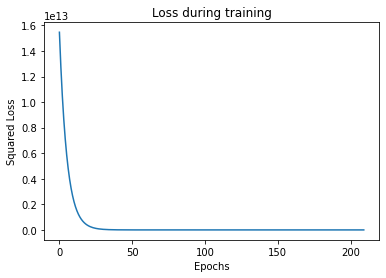

In [ ]:
loss_graph = []

def least_squares_fit(params, 
                      xs,
                      ys,
                      learning_rate: float = 0.0001,
                      num_steps: int = 1000,
                      batch_size: int = 1):
  # Start with a random guesses in params['w']
  for _ in tqdm.trange(num_steps, desc="least squares fit"):
    for start in range(0, len(xs), batch_size):
      batch_xs = xs[start:start+batch_size]
      batch_ys = ys[start:start+batch_size]

      gradient = grad_fn(params, batch_xs, batch_ys)
      params['w'] -= learning_rate * gradient['w']
      params['b'] -= learning_rate * gradient['b']

      loss = loss_fn(params, x_train, y_train)
    
    loss_graph.append(loss)
    print(' loss:', loss)
  return params['w']

x_axis = jnp.array([i for i in range(len(dataset))])

beta = least_squares_fit(params, x_train, y_train, 0.00000000000000001, 210, 30)

plt.title("Loss during training")
plt.ylabel("Squared Loss")
plt.xlabel("Epochs")
plt.plot(loss_graph)

Beta values:  [ 1.8160863e+00 -7.5488496e-01  3.3989221e-01 -8.8394991e-06]
Slope: [ 1.8160863e+00 -7.5488496e-01  3.3989221e-01 -8.8394991e-06]
y-intercept: 4.7917933e-08
Loss: 4.7917933e-08


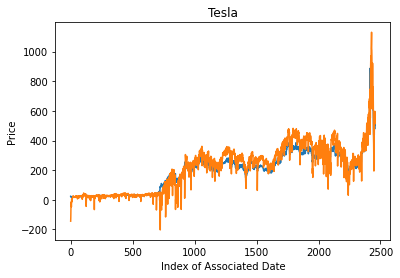

In [ ]:
line = [forward(params, i) for i in x] 

plt.title("Tesla")
plt.ylabel("Price")
plt.xlabel("Index of Associated Date")
plt.plot(x_axis,y)
plt.plot(x_axis,line)

print("Beta values: ", params['w'])
print('Slope:', beta)
print('y-intercept:', params['b'])
print('Loss:', params['b'])


The orange line is the prediction and the blue line is the original dataset. Now that we have a regression model, we can predict the stock price by giving a 'x' value. 

In [ ]:
#Getting rid of these comments?

# plt.title("Alliancebernstein Holding LP")
# plt.ylabel("Price")
# plt.xlabel("Index of Associated Date")

# plt.plot(dates, close)
# print(beta)

predicted_y = []

# print(len(x))

for i in range(len(x)):
  predicted_y.append(forward(params, x[i]))

print(params)

#plt.plot(x_axis, predicted_y)

{'w': DeviceArray([ 1.8160863e+00, -7.5488496e-01,  3.3989221e-01,
             -8.8394991e-06], dtype=float32), 'b': DeviceArray(4.7917933e-08, dtype=float32, weak_type=True)}


Average squared loss for test dataset: 2660.9846


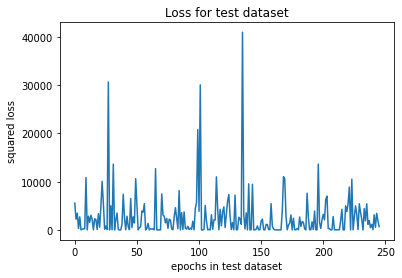

In [ ]:
#This part broken for some reason?

total_loss = 0 
loss_arr = []
for sample, ground_truth in zip(x_test, y_test):
  loss = loss_fn(params, jnp.array(sample),jnp.array(ground_truth))
  # print(loss)
  loss_arr.append(loss)
  total_loss += loss


plt.xlabel('epochs in test dataset')
plt.ylabel('squared loss')
plt.title('Loss for test dataset')
plt.plot(loss_arr)
print('Average squared loss for test dataset:', total_loss/len(x_test))


## Rough Work / Failed implementation

In [ ]:
print(beta)
# print(len(x),' + ', len(y))

curve = [] # theses are our predictions after training model
for i in range(len(x)):
  prediction = jit_predict(jnp.array(x[i]),beta)
  curve.append(prediction)

plt.plot(curve) # the shape is starting to match(only a little though) but the values are too high. I guesss we need to add some bias and tone down the predictions


[ 1.8160863e+00 -7.5488496e-01  3.3989221e-01 -8.8394991e-06]


NameError: ignored

In [ ]:
import random
from typing import List
import tqdm

x1 = data['Open'].values
x2 = data['Close'].values
x3 = data['Volume'].values
# x4 = data['High'].values

x = []
for i in range(len(dates)):
  x.append([1, x1[i], x2[i], x3[i]])

x = jnp.array(x) # converted to jnp array
#y = data['Adj Close'].values # this is what we need to predict
y = jnp.array(data['Adj Close'])

assert len(x) == len(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.1, random_state=0)

In [ ]:
#experimental code
x1 = data['Open']
x2 = data['Close']
x3 = data['Volume']

n = 3

#specify the dimesions
#x = jnp.empty((len(x1), n + 1))
x = []

print(x)

for i in range(len(dates)):
  x.append([1, x1[i], x2[i], x3[i]])
  #jnp.append(x, jnp.array([1, x1[i], x2[i], x3[i]]))
  #x.at[i].set(jnp.array([1, x1[i], x2[i], x3[i]]))
  #x.at[i]

x = jnp.array(x)
y = jnp.array(data['Adj Close'].values) # this is what we need to predict

#assert len(x) == len(y)

[]


In [ ]:
from jax._src.numpy.ndarray import ndarray

#THE JAX EXPERIMENTAL VERSION.

#Jit code ideas
@jax.jit
def jadd(a, b):
  return a + b
  
jit_add = jit(jadd)

def jerror():
  return 0

#Might be able to get rid of add and put return value in gradient descent.
@jax.jit
def add(v, w):
  """Adds corresponding elements"""
  assert len(v) == len(w), "vectors must be the same length"
  return jnp.array([v_i + w_i for v_i, w_i in zip(v, w)])

jit_add = jit(add)

#Might be able to delete this and put return value in predict
def dot(v, w) -> float:
  """Computes v_1 * w_1 + ... + v_n * w_n"""
  assert len(v) == len(w), "vectors must be same length"
  #return sum(vi * wi for vi, wi in zip(v, w))
  #return jnp.dot(v, w)

jit_dot = jit(dot)

@jax.jit
def predict(v, w) -> float:
  """assumes that the first element of x is 1"""
  #return dot(x, beta) #Delete this?!
  #return sum(vi * wi for vi, wi in zip(v, w))
  # v = jnp.array(v)
  #return jit_dot(v, w)
  return jnp.dot(v, w)

jit_predict = jit(predict)

@jax.jit
def vector_sum(vectors):
  """Sums all corresponding elements"""
  # Check that vectors is not empty
  assert vectors, "no vectors provided!"

  # Check the vectors are all the same size
  num_elements = len(vectors[0])
  assert all(len(v) == num_elements for v in vectors), "different sizes!"

  # the i-th element of the result is the sum of every vector[i]
  return jnp.array([sum(vector[i] for vector in vectors)
    for i in range(num_elements)])

jit_vector_sum = jit(vector_sum)

@jax.jit
def vector_mean(vectors):
  """Computes the element-wise average"""
  n = len(vectors)
  return scalar_multiply(1/n, vector_sum(vectors))

@jax.jit
def scalar_multiply(c: float, v):
  """Multiplies every element by c"""
  return jnp.array([c * v_i for v_i in v])

jit_scalar_multiply = jit(scalar_multiply)

@jax.jit
def gradient_step(v, gradient, step_size: float):
  """Moves `step_size` in the `gradient` direction from `v`"""
  assert len(v) == len(gradient)
  step = jit_scalar_multiply(step_size, gradient)
  #Adding all []
  return add(v, step)

@jax.jit
def error(x, y: float, beta) -> float:
  return predict(x, beta) - y

jit_error = jit(error)

@jax.jit
#This is not used anywhere I dont think
def squared_error(x, y: float, beta) -> float:
  return error(x, y, beta) ** 2

@jax.jit
def jsqerror_comp(err, xi):
  return 2 * err * xi

jit_sqerror = jit(jsqerror_comp)

"""
@jax.jit
def sqerror_gradient(x: ndarray, y: float, beta: ndarray):
  err = error(x, y, beta)
  return jnp.array([2 * err * x_i for x_i in x])"""

def sqerror_gradient(x: ndarray, y: float, beta: ndarray):
  err = error(x, y, beta)
  return jnp.array([2 * err * x_i for x_i in x])

jit_sqerror_gradient = jit(sqerror_gradient)

def least_squares_fit(xs,
                      ys,
                      learning_rate: float = 0.001,
                      num_steps: int = 1000,
                      batch_size: int = 1):
  # Start with a random guess
  guess = jnp.array([random.random() for _ in xs[0]])

  print(guess)
  for _ in tqdm.trange(num_steps, desc="least squares fit"):
    for start in range(0, len(xs), batch_size):
      #range(start, stop, step)
      batch_xs = xs[start:start+batch_size]
      batch_ys = ys[start:start+batch_size]
      
      gradient = vector_mean([jit_sqerror_gradient(x, y, guess) for x, y in zip(batch_xs, batch_ys)])
      guess = gradient_step(guess, gradient, -learning_rate)
    #print(guess)
  return guess

#previous
#beta = least_squares_fit(x, y, 0.000000000001, 100, 1)

beta = least_squares_fit(x_train, y_train, 0.000000000001, 210, 30)
print(beta)

[0.3323114  0.69887143 0.8297505  0.54068017 0.7718682 ]


least squares fit:   0%|          | 1/210 [00:02<09:00,  2.59s/it]


KeyboardInterrupt: ignored

In [ ]:
#Working Code
Vector = List[float]

def add(v: Vector, w: Vector) -> Vector:
    """Adds corresponding elements"""
    assert len(v) == len(w), "vectors must be the same length"
    return [v_i + w_i for v_i, w_i in zip(v, w)]

def dot(v: Vector, w: Vector) -> float:
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def predict(x: Vector, beta: Vector) -> float:
 """assumes that the first element of x is 1"""
 return dot(x, beta)

def vector_sum(vectors: List[Vector]) -> Vector:
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"

    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def vector_mean(vectors: List[Vector]) -> Vector:
    """Computes the element-wise average"""
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

def scalar_multiply(c: float, v: Vector) -> Vector:
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def gradient_step(v: Vector, gradient: Vector, step_size: float) -> Vector:
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

def error(x: Vector, y: float, beta: Vector) -> float:
 return predict(x, beta) - y

jit_error = jit(error)

#This is not used anywhere I dont think
def squared_error(x: Vector, y: float, beta: Vector) -> float:
 return error(x, y, beta) ** 2

def sqerror_gradient(x: Vector, y: float, beta: Vector) -> Vector:
 err = error(x, y, beta)
 return [2 * err * x_i for x_i in x]

def least_squares_fit(xs,
                      ys,
                      learning_rate: float = 0.001,
                      num_steps: int = 1000,
                      batch_size: int = 1):
  # Start with a random guess
  guess = [random.random() for _ in xs[0]]
  print(guess)
  for _ in tqdm.trange(num_steps, desc="least squares fit"):
    for start in range(0, len(xs), batch_size):
      #range(start, stop, step)
      batch_xs = xs[start:start+batch_size]
      batch_ys = ys[start:start+batch_size]

      gradient = vector_mean([sqerror_gradient(x, y, guess) for x, y in zip(batch_xs, batch_ys)])
      guess = gradient_step(guess, gradient, -learning_rate)
    print(guess)

  return guess

#previous
#beta = least_squares_fit(x, y, 0.000000000001, 100, 1)
beta = least_squares_fit(x_train, y_train, 0.00000000001, 400, 30)


[0.24665606667023898, 0.6820507949846255, 0.3088961031048443, 0.2691434064821262, 0.22592861799106212]


least squares fit:   0%|          | 2/400 [00:00<00:27, 14.64it/s]

[0.24665179023148595, 0.6819128761838802, 0.308759615521229, -3.289210246633367e-05, 0.22578906676372176]
[0.2466515709713142, 0.6819004259970312, 0.30874754408571803, -3.292373130635218e-05, 0.22577661381480274]
[0.2466513517218573, 0.6818879764043284, 0.3087354732265597, -3.2921397680613556e-05, 0.22576416146015751]


least squares fit:   1%|          | 4/400 [00:00<00:27, 14.57it/s]

[0.24665113248260317, 0.681875527389914, 0.30872340292802974, -3.291906415896967e-05, 0.22575170968372293]
[0.24665091325355137, 0.6818630789537609, 0.3087113331901029, -3.291673074570118e-05, 0.22573925848547213]


least squares fit:   2%|▏         | 6/400 [00:00<00:30, 13.10it/s]

[0.24665069403470136, 0.6818506310958415, 0.30869926401275294, -3.291439744080327e-05, 0.22572680786537835]
[0.24665047482605254, 0.6818381838161297, 0.30868719539595363, -3.291206424426994e-05, 0.22571435782341476]


least squares fit:   2%|▏         | 8/400 [00:00<00:29, 13.31it/s]

[0.24665025562760412, 0.6818257371145984, 0.30867512733967895, -3.290973115609715e-05, 0.2257019083595544]


least squares fit:   2%|▎         | 10/400 [00:00<00:29, 13.43it/s]

[0.2466500364393563, 0.6818132909912198, 0.30866305984390263, -3.2907398176279276e-05, 0.2256894594737704]
[0.24664981726130847, 0.6818008454459689, 0.3086509929085988, -3.2905065304812e-05, 0.22567701116603622]
[0.24664959809345993, 0.6817884004788186, 0.3086389265337416, -3.290273254168968e-05, 0.22566456343632457]


least squares fit:   3%|▎         | 12/400 [00:00<00:29, 13.20it/s]

[0.2466493789358103, 0.6817759560897413, 0.30862686071930523, -3.290039988690744e-05, 0.22565211628460846]
[0.24664915978835925, 0.6817635122787105, 0.3086147954652631, -3.289806734046e-05, 0.22563966971086152]


least squares fit:   4%|▎         | 14/400 [00:01<00:28, 13.58it/s]

[0.24664894065110607, 0.6817510690456997, 0.308602730771589, -3.2895734902342434e-05, 0.22562722371505703]


least squares fit:   4%|▍         | 16/400 [00:01<00:28, 13.63it/s]

[0.24664872152405046, 0.6817386263906814, 0.30859066663825796, -3.289340257255012e-05, 0.22561477829716736]
[0.24664850240719155, 0.6817261843136289, 0.3085786030652428, -3.289107035107771e-05, 0.2256023334571666]
[0.24664828330052935, 0.6817137428145158, 0.3085665400525184, -3.2888738237920516e-05, 0.22558988919502743]


least squares fit:   5%|▌         | 20/400 [00:01<00:28, 13.50it/s]

[0.24664806420406332, 0.6817013018933145, 0.3085544776000578, -3.2886406233072744e-05, 0.22557744551072284]
[0.24664784511779267, 0.6816888615499989, 0.30854241570783597, -3.288407433652994e-05, 0.22556500240422653]
[0.24664762604171733, 0.6816764217845425, 0.3085303543758264, -3.288174254828718e-05, 0.22555255987551123]


least squares fit:   6%|▌         | 22/400 [00:01<00:28, 13.48it/s]

[0.2466474069758365, 0.6816639825969172, 0.30851829360400346, -3.287941086833913e-05, 0.2255401179245503]
[0.2466471879201499, 0.6816515439870964, 0.3085062333923402, -3.287707929668076e-05, 0.22552767655131667]
[0.24664696887465706, 0.6816391059550542, 0.30849417374081156, -3.2874747833307104e-05, 0.2255152357557839]


least squares fit:   6%|▋         | 26/400 [00:01<00:27, 13.65it/s]

[0.2466467498393575, 0.6816266685007631, 0.30848211464939135, -3.287241647821313e-05, 0.22550279553792507]
[0.24664653081425078, 0.6816142316241961, 0.3084700561180534, -3.2870085231393966e-05, 0.22549035589771305]
[0.2466463117993362, 0.6816017953253264, 0.30845799814677144, -3.286775409284433e-05, 0.22547791683512117]


least squares fit:   7%|▋         | 28/400 [00:02<00:27, 13.66it/s]

[0.24664609279461297, 0.6815893596041269, 0.3084459407355196, -3.286542306255961e-05, 0.22546547835012254]
[0.24664587380008124, 0.6815769244605718, 0.3084338838842721, -3.2863092140533905e-05, 0.22545304044269057]
[0.24664565481574027, 0.681564489894635, 0.30842182759300274, -3.286076132676336e-05, 0.22544060311279834]


least squares fit:   8%|▊         | 32/400 [00:02<00:26, 13.65it/s]

[0.24664543584158977, 0.6815520559062879, 0.3084097718616851, -3.285843062124204e-05, 0.22542816636041882]
[0.24664521687762903, 0.6815396224955033, 0.30839771669029425, -3.285610002396533e-05, 0.22541573018552546]
[0.24664499792385766, 0.6815271896622557, 0.30838566207880336, -3.285376953492803e-05, 0.22540329458809136]
[0.24664477898027556, 0.6815147574065181, 0.308373608027187, -3.285143915412524e-05, 0.22539085956808982]


least squares fit:   9%|▉         | 36/400 [00:02<00:26, 13.77it/s]

[0.24664456004688204, 0.6815023257282629, 0.3083615545354184, -3.2849108881551965e-05, 0.22537842512549375]
[0.2466443411236765, 0.6814898946274642, 0.308349501603472, -3.2846778717202934e-05, 0.22536599126027626]
[0.2466441222106585, 0.681477464104094, 0.30833744923132256, -3.2844448661073326e-05, 0.22535355797241086]


least squares fit:  10%|▉         | 38/400 [00:02<00:26, 13.83it/s]

[0.24664390330782743, 0.681465034158127, 0.30832539741894255, -3.284211871315788e-05, 0.22534112526187056]
[0.24664368441518342, 0.6814526047895358, 0.30831334616630734, -3.283978887345201e-05, 0.22532869312862835]
[0.24664346553272504, 0.6814401759982939, 0.30830129547338997, -3.2837459141950436e-05, 0.22531626157265802]


least squares fit:  10%|█         | 42/400 [00:03<00:25, 13.79it/s]

[0.2466432466604524, 0.6814277477843733, 0.3082892453401649, -3.2835129518648214e-05, 0.22530383059393225]
[0.2466430277983649, 0.6814153201477476, 0.30827719576660567, -3.283280000354007e-05, 0.22529140019242463]
[0.24664280894646212, 0.6814028930883907, 0.30826514675268707, -3.28304705966209e-05, 0.22527897036810784]


least squares fit:  12%|█▏        | 46/400 [00:03<00:25, 14.10it/s]

[0.24664259010474365, 0.6813904666062756, 0.3082530982983822, -3.282814129788636e-05, 0.22526654112095562]
[0.24664237127320915, 0.6813780407013749, 0.30824105040366634, -3.2825812107330966e-05, 0.2252541124509405]
[0.24664215245185753, 0.6813656153736621, 0.30822900306851236, -3.282348302494946e-05, 0.2252416843580362]
[0.24664193364068884, 0.6813531906231103, 0.3082169562928941, -3.282115405073745e-05, 0.22522925684221573]


least squares fit:  12%|█▏        | 48/400 [00:03<00:25, 13.54it/s]

[0.24664171483970235, 0.681340766449693, 0.3082049100767857, -3.2818825184689144e-05, 0.22521682990345226]
[0.24664149604889807, 0.6813283428533837, 0.30819286442016214, -3.281649642680002e-05, 0.22520440354171903]
[0.24664127726827464, 0.6813159198341545, 0.30818081932299685, -3.281416777706504e-05, 0.22519197775698926]


least squares fit:  13%|█▎        | 52/400 [00:03<00:25, 13.82it/s]

[0.2466410584978324, 0.6813034973919795, 0.3081687747852642, -3.2811839235478876e-05, 0.22517955254923647]
[0.2466408397375707, 0.6812910755268311, 0.3081567308069374, -3.280951080203716e-05, 0.22516712791843344]
[0.2466406209874889, 0.6812786542386836, 0.3081446873879913, -3.280718247673407e-05, 0.22515470386455325]


least squares fit:  14%|█▎        | 54/400 [00:03<00:25, 13.80it/s]

[0.2466404022475865, 0.6812662335275101, 0.3081326445283993, -3.2804854259565124e-05, 0.22514228038756948]
[0.24664018351786304, 0.6812538133932834, 0.3081206022281356, -3.28025261505251e-05, 0.22512985748745523]
[0.24663996479831832, 0.6812413938359762, 0.3081085604871742, -3.2800198149608576e-05, 0.22511743516418395]


least squares fit:  14%|█▍        | 58/400 [00:04<00:25, 13.41it/s]

[0.24663974608895192, 0.6812289748555612, 0.30809651930548937, -3.2797870256811226e-05, 0.22510501341772837]
[0.24663952738976305, 0.6812165564520134, 0.30808447868305533, -3.27955424721279e-05, 0.225092592248062]
[0.24663930870075126, 0.6812041386253058, 0.30807243861984596, -3.2793214795553545e-05, 0.22508017165515778]
[0.2466390900219158, 0.6811917213754117, 0.3080603991158347, -3.2790887227082726e-05, 0.22506775163898926]


least squares fit:  16%|█▌        | 62/400 [00:04<00:25, 13.30it/s]

[0.24663887135325682, 0.6811793047023024, 0.3080483601709957, -3.2788559766710996e-05, 0.22505533219952953]
[0.24663865269477359, 0.6811668886059519, 0.30803632178530355, -3.278623241443296e-05, 0.22504291333675164]
[0.2466384340464656, 0.6811544730863349, 0.3080242839587324, -3.278390517024379e-05, 0.22503049505062908]


least squares fit:  16%|█▋        | 66/400 [00:04<00:24, 13.75it/s]

[0.24663821540833242, 0.6811420581434241, 0.30801224669125554, -3.278157803413802e-05, 0.22501807734113485]
[0.24663799678037338, 0.6811296437771908, 0.30800020998284794, -3.277925100611118e-05, 0.2250056602082425]
[0.24663777816258814, 0.6811172299876107, 0.3079881738334829, -3.277692408615848e-05, 0.22499324365192475]
[0.24663755955497643, 0.6811048167746548, 0.30797613824313474, -3.2774597274273925e-05, 0.22498082767215508]


least squares fit:  17%|█▋        | 68/400 [00:04<00:24, 13.62it/s]

[0.2466373409575376, 0.6810924041382982, 0.30796410321177714, -3.2772270570453375e-05, 0.22496841226890685]
[0.24663712237027113, 0.6810799920785127, 0.3079520687393842, -3.2769943974691665e-05, 0.22495599744215306]
[0.2466369037931764, 0.6810675805952734, 0.30794003482593, -3.276761748698287e-05, 0.224943583191867]


least squares fit:  18%|█▊        | 72/400 [00:05<00:23, 13.92it/s]

[0.24663668522625326, 0.6810551696885512, 0.3079280014713891, -3.276529110732321e-05, 0.2249311695180221]
[0.24663646666950112, 0.681042759358321, 0.30791596867573473, -3.2762964835707364e-05, 0.22491875642059125]
[0.24663624812291957, 0.6810303496045554, 0.30790393643894126, -3.2760638672129565e-05, 0.22490634389954778]


least squares fit:  18%|█▊        | 74/400 [00:05<00:23, 13.83it/s]

[0.24663602958650804, 0.6810179404272272, 0.30789190476098305, -3.2758312616585166e-05, 0.22489393195486507]
[0.24663581106026622, 0.6810055318263101, 0.30787987364183406, -3.2755986669069846e-05, 0.2248815205865163]
[0.2466355925441933, 0.6809931238017775, 0.3078678430814679, -3.27536608295779e-05, 0.22486910979447444]


least squares fit:  20%|█▉        | 78/400 [00:05<00:23, 13.89it/s]

[0.24663537403828914, 0.6809807163536019, 0.30785581307985915, -3.275133509810432e-05, 0.22485669957871318]
[0.24663515554255305, 0.6809683094817583, 0.30784378363698095, -3.27490094746444e-05, 0.2248442899392056]
[0.2466349370569845, 0.6809559031862192, 0.30783175475280894, -3.2746683959193604e-05, 0.22483188087592462]


least squares fit:  20%|██        | 82/400 [00:05<00:22, 14.23it/s]

[0.24663471858158295, 0.6809434974669557, 0.30781972642731614, -3.2744358551745596e-05, 0.2248194723888438]
[0.24663450011634824, 0.6809310923239427, 0.3078076986604764, -3.2742033252295725e-05, 0.22480706447793627]
[0.24663428166128012, 0.6809186877571531, 0.30779567145226433, -3.27397080608396e-05, 0.22479465714317548]
[0.24663406321637785, 0.6809062837665615, 0.30778364480265347, -3.273738297737194e-05, 0.22478225038453425]


least squares fit:  21%|██        | 84/400 [00:06<00:22, 14.12it/s]

[0.24663384478164066, 0.6808938803521392, 0.3077716187116184, -3.273505800188761e-05, 0.2247698442019862]
[0.24663362635706862, 0.6808814775138609, 0.30775959317913304, -3.2732733134382356e-05, 0.2247574385955044]
[0.24663340794266078, 0.6808690752516999, 0.3077475682051712, -3.2730408374849514e-05, 0.22474503356506212]


least squares fit:  22%|██▏       | 88/400 [00:06<00:22, 13.88it/s]

[0.24663318953841687, 0.6808566735656283, 0.30773554378970674, -3.2728083723285306e-05, 0.22473262911063283]
[0.24663297114433616, 0.6808442724556194, 0.3077235199327139, -3.272575917968438e-05, 0.22472022523218946]
[0.24663275276041854, 0.6808318719216474, 0.30771149663416714, -3.272343474404207e-05, 0.22470782192970531]
[0.24663253438666347, 0.6808194719636852, 0.30769947389404073, -3.2721110416352765e-05, 0.22469541920315336]


least squares fit:  23%|██▎       | 92/400 [00:06<00:22, 13.77it/s]

[0.24663231602307045, 0.6808070725817051, 0.3076874517123082, -3.27187861966117e-05, 0.22468301705250754]
[0.24663209766963912, 0.6807946737756821, 0.30767543008894344, -3.271646208481429e-05, 0.2246706154777407]
[0.24663187932636885, 0.6807822755455879, 0.3076634090239207, -3.2714138080955224e-05, 0.2246582144788262]


least squares fit:  24%|██▎       | 94/400 [00:06<00:22, 13.47it/s]

[0.24663166099325917, 0.6807698778913966, 0.307651388517214, -3.2711814185028986e-05, 0.22464581405573741]
[0.24663144267030954, 0.6807574808130816, 0.3076393685687976, -3.270949039703147e-05, 0.22463341420844715]
[0.24663122435751958, 0.680745084310616, 0.30762734917864637, -3.270716671695683e-05, 0.22462101493692913]


least squares fit:  24%|██▍       | 98/400 [00:07<00:21, 13.82it/s]

[0.24663100605488872, 0.6807326883839716, 0.3076153303467331, -3.2704843144800645e-05, 0.22460861624115627]
[0.24663078776241665, 0.6807202930331236, 0.3076033120730323, -3.270251968055746e-05, 0.22459621812110192]
[0.24663056948010287, 0.6807078982580449, 0.30759129435751775, -3.270019632422238e-05, 0.2245838205767397]


least squares fit:  26%|██▌       | 102/400 [00:07<00:21, 13.99it/s]

[0.24663035120794674, 0.6806955040587083, 0.3075792772001641, -3.2697873075790974e-05, 0.22457142360804258]
[0.246630132945948, 0.6806831104350876, 0.307567260600945, -3.2695549935257215e-05, 0.22455902721498358]
[0.246629914694106, 0.6806707173871558, 0.3075552445598346, -3.2693226902617037e-05, 0.22454663139753658]
[0.24662969645242047, 0.6806583249148852, 0.3075432290768068, -3.269090397786503e-05, 0.22453423615567414]


least squares fit:  26%|██▌       | 104/400 [00:07<00:21, 13.47it/s]

[0.24662947822089096, 0.6806459330182502, 0.3075312141518363, -3.268858116099595e-05, 0.22452184148936996]
[0.24662925999951685, 0.6806335416972239, 0.3075191997848969, -3.2686258452005205e-05, 0.22450944739859713]
[0.24662904178829773, 0.6806211509517789, 0.3075071859759621, -3.26839358508874e-05, 0.2244970538833289]


least squares fit:  27%|██▋       | 108/400 [00:07<00:21, 13.55it/s]

[0.2466288235872327, 0.680608760781889, 0.3074951727250069, -3.268161335763776e-05, 0.2244846609435388]
[0.24662860539632178, 0.6805963711875268, 0.30748316003200504, -3.2679290972250976e-05, 0.22447226857919994]
[0.24662838721556452, 0.680583982168667, 0.30747114789693064, -3.267696869472296e-05, 0.22445987679028562]


least squares fit:  28%|██▊       | 112/400 [00:08<00:20, 13.93it/s]

[0.24662816904496024, 0.6805715937252818, 0.3074591363197576, -3.267464652504728e-05, 0.2244474855767692]
[0.24662795088450873, 0.6805592058573453, 0.3074471253004599, -3.267232446322009e-05, 0.22443509493862396]
[0.2466277327342091, 0.6805468185648296, 0.30743511483901176, -3.267000250923559e-05, 0.22442270487582314]
[0.24662751459406124, 0.6805344318477091, 0.30742310493538744, -3.266768066308975e-05, 0.22441031538833983]


least squares fit:  29%|██▉       | 116/400 [00:08<00:20, 14.09it/s]

[0.24662729646406442, 0.6805220457059565, 0.30741109558956115, -3.266535892477651e-05, 0.22439792647614737]
[0.24662707834421818, 0.680509660139546, 0.30739908680150646, -3.26630372942914e-05, 0.22438553813921916]
[0.2466268602345224, 0.6804972751484493, 0.3073870785711979, -3.266071577162932e-05, 0.2243731503775286]
[0.24662664213497626, 0.6804848907326395, 0.3073750708986098, -3.2658394356785344e-05, 0.22436076319104856]


least squares fit:  30%|██▉       | 118/400 [00:08<00:21, 13.20it/s]

[0.24662642404557944, 0.6804725068920913, 0.3073630637837158, -3.265607304975447e-05, 0.22434837657975276]
[0.2466262059663314, 0.680460123626778, 0.30735105722649, -3.265375185053195e-05, 0.22433599054361422]
[0.24662598789723164, 0.680447740936672, 0.3073390512269065, -3.2651430759111916e-05, 0.22432360508260632]


least squares fit:  30%|███       | 122/400 [00:08<00:20, 13.52it/s]

[0.24662576983827983, 0.680435358821748, 0.3073270457849393, -3.264910977548989e-05, 0.22431122019670255]
[0.24662555178947534, 0.680422977281977, 0.30731504090056294, -3.2646788899661294e-05, 0.22429883588587582]
[0.24662533375081785, 0.6804105963173331, 0.30730303657375085, -3.264446813162004e-05, 0.22428645215009974]


least squares fit:  31%|███       | 124/400 [00:09<00:20, 13.53it/s]

[0.24662511572230694, 0.6803982159277905, 0.30729103280447817, -3.264214747136218e-05, 0.22427406898934746]
[0.24662489770394194, 0.6803858361133222, 0.3072790295927184, -3.263982691888219e-05, 0.22426168640359206]
[0.24662467969572238, 0.6803734568739008, 0.3072670269384458, -3.2637506474175214e-05, 0.22424930439280708]


least squares fit:  32%|███▏      | 128/400 [00:09<00:19, 13.68it/s]

[0.246624461697648, 0.6803610782095014, 0.30725502484163425, -3.263518613723647e-05, 0.22423692295696593]
[0.24662424370971792, 0.6803487001200961, 0.30724302330225767, -3.263286590806011e-05, 0.22422454209604187]
[0.24662402573193215, 0.6803363226056565, 0.3072310223202906, -3.263054578664189e-05, 0.22421216181000764]


least squares fit:  32%|███▎      | 130/400 [00:09<00:19, 13.64it/s]

[0.24662380776428994, 0.6803239456661584, 0.3072190218957066, -3.262822577297696e-05, 0.2241997820988372]
[0.24662358980679128, 0.6803115693015738, 0.30720702202848077, -3.2625905867059567e-05, 0.22418740296250364]
[0.24662337185943506, 0.680299193511877, 0.307195022718587, -3.2623586068885495e-05, 0.22417502440098028]


least squares fit:  34%|███▎      | 134/400 [00:09<00:19, 13.35it/s]

[0.2466231539222208, 0.6802868182970402, 0.3071830239659987, -3.2621266378449055e-05, 0.22416264641424036]
[0.24662293599514828, 0.6802744436570378, 0.30717102577069, -3.261894679574573e-05, 0.22415026900225735]
[0.24662271807821726, 0.6802620695918415, 0.3071590281326356, -3.2616627320770445e-05, 0.22413789216500432]


least squares fit:  34%|███▍      | 136/400 [00:09<00:19, 13.49it/s]

[0.2466225001714271, 0.6802496961014263, 0.3071470310518091, -3.2614307953517894e-05, 0.22412551590245486]
[0.2466222822747773, 0.6802373231857647, 0.307135034528185, -3.261198869398316e-05, 0.22411314021458223]
[0.24662206438826706, 0.6802249508448297, 0.3071230385617375, -3.260966954216161e-05, 0.2241007651013594]


least squares fit:  35%|███▌      | 140/400 [00:10<00:18, 13.90it/s]

[0.24662184651189664, 0.6802125790785947, 0.30711104315244003, -3.260735049804806e-05, 0.22408839056275998]
[0.24662162864566486, 0.6802002078870344, 0.3070990483002674, -3.260503156163718e-05, 0.2240760165987572]
[0.24662141078957162, 0.6801878372701196, 0.30708705400519354, -3.2602712732923974e-05, 0.2240636432093245]


least squares fit:  36%|███▌      | 142/400 [00:10<00:18, 14.03it/s]

[0.24662119294361626, 0.6801754672278255, 0.3070750602671924, -3.260039401190403e-05, 0.224051270394435]
[0.24662097510779846, 0.6801630977601253, 0.3070630670862387, -3.2598075398571855e-05, 0.2240388981540621]
[0.2466207572821175, 0.6801507288669919, 0.3070510744623061, -3.259575689292272e-05, 0.22402652648817906]


least squares fit:  36%|███▋      | 146/400 [00:10<00:18, 13.73it/s]

[0.2466205394665732, 0.6801383605483985, 0.3070390823953691, -3.25934384949517e-05, 0.22401415539675928]
[0.24662032166116513, 0.6801259928043182, 0.307027090885401, -3.2591120204653265e-05, 0.22400178487977607]
[0.2466201038658926, 0.6801136256347251, 0.3070150999323771, -3.2588802022022925e-05, 0.22398941493720284]


least squares fit:  37%|███▋      | 148/400 [00:10<00:18, 13.74it/s]

[0.24661988608075525, 0.6801012590395928, 0.30700310953627036, -3.2586483947055284e-05, 0.2239770455690127]
[0.24661966830575263, 0.6800888930188942, 0.30699111969705567, -3.2584165979745734e-05, 0.2239646767751792]
[0.24661945054088413, 0.6800765275726022, 0.30697913041470637, -3.258184812008892e-05, 0.22395230855567538]


least squares fit:  38%|███▊      | 154/400 [00:11<00:17, 14.07it/s]

[0.24661923278614908, 0.6800641627006904, 0.3069671416891976, -3.257953036808009e-05, 0.22393994091047487]
[0.24661901504154773, 0.6800517984031312, 0.3069551535205032, -3.257721272371455e-05, 0.2239275738395507]
[0.2466187973070791, 0.680039434679899, 0.306943165908597, -3.25748951869867e-05, 0.22391520734287637]
[0.24661857958274294, 0.6800270715309671, 0.30693117885345356, -3.2572577757891414e-05, 0.22390284142042527]
[0.24661836186853853, 0.6800147089563084, 0.3069191923550462, -3.2570260436424225e-05, 0.22389047607217075]


least squares fit:  39%|███▉      | 156/400 [00:11<00:17, 14.08it/s]

[0.24661814416446554, 0.6800023469558957, 0.30690720641334973, -3.2567943222579904e-05, 0.22387811129808574]
[0.24661792647052333, 0.6799899855297031, 0.30689522102833866, -3.256562611635353e-05, 0.22386574709814402]
[0.24661770878671174, 0.679977624677704, 0.3068832361999862, -3.256330911774009e-05, 0.22385338347231876]


least squares fit:  40%|████      | 160/400 [00:11<00:17, 13.39it/s]

[0.24661749111303014, 0.6799652643998708, 0.30687125192826736, -3.256099222673445e-05, 0.22384102042058346]
[0.24661727344947776, 0.6799529046961801, 0.306859268213156, -3.2558675443332026e-05, 0.2238286579429113]
[0.24661705579605434, 0.6799405455666023, 0.3068472850546261, -3.2556358767527505e-05, 0.22381629603927558]


least squares fit:  41%|████      | 164/400 [00:11<00:17, 13.79it/s]

[0.2466168381527598, 0.6799281870111102, 0.30683530245265206, -3.2554042199315426e-05, 0.22380393470964977]
[0.24661662051959332, 0.6799158290296784, 0.30682332040720744, -3.255172573869178e-05, 0.22379157395400712]
[0.2466164028965543, 0.6799034716222809, 0.306811338918267, -3.2549409385651114e-05, 0.2237792137723212]
[0.24661618528364254, 0.6798911147888893, 0.3067993579858047, -3.254709314018805e-05, 0.2237668541645651]


least squares fit:  42%|████▏     | 168/400 [00:12<00:16, 14.04it/s]

[0.24661596768085745, 0.6798787585294775, 0.3067873776097949, -3.2544777002298106e-05, 0.2237544951307123]
[0.24661575008819844, 0.6798664028440189, 0.3067753977902114, -3.25424609719761e-05, 0.2237421366707359]
[0.24661553250566542, 0.6798540477324876, 0.30676341852702876, -3.2540145049217344e-05, 0.22372977878460953]
[0.24661531493325767, 0.6798416931948565, 0.3067514398202209, -3.253782923401589e-05, 0.22371742147230644]


least squares fit:  42%|████▎     | 170/400 [00:12<00:16, 13.93it/s]

[0.24661509737097456, 0.6798293392311003, 0.30673946166976135, -3.253551352636794e-05, 0.22370506473379992]
[0.2466148798188157, 0.6798169858411897, 0.3067274840756248, -3.2533197926267805e-05, 0.22369270856906318]
[0.2466146622767805, 0.6798046330250993, 0.306715507037786, -3.2530882433710564e-05, 0.22368035297807012]


least squares fit:  44%|████▎     | 174/400 [00:12<00:16, 13.48it/s]

[0.24661444474486885, 0.6797922807828013, 0.30670353055621896, -3.2528567048691406e-05, 0.22366799796079384]
[0.2466142272230804, 0.6797799291142712, 0.3066915546308975, -3.2526251771204965e-05, 0.2236556435172074]
[0.24661400971141428, 0.6797675780194812, 0.30667957926179557, -3.252393660124688e-05, 0.2236432896472843]
[0.24661379220987054, 0.6797552274984047, 0.3066676044488878, -3.252162153881145e-05, 0.2236309363509977]


least squares fit:  44%|████▍     | 178/400 [00:13<00:16, 13.57it/s]

[0.246613574718448, 0.6797428775510145, 0.3066556301921478, -3.251930658389391e-05, 0.22361858362832135]
[0.24661335723714659, 0.6797305281772855, 0.3066436564915501, -3.2516991736489966e-05, 0.22360623147922853]
[0.2466131397659657, 0.6797181793771903, 0.30663168334706864, -3.2514676996593436e-05, 0.2235938799036923]


least squares fit:  45%|████▌     | 180/400 [00:13<00:16, 13.38it/s]

[0.24661292230490478, 0.6797058311507017, 0.3066197107586779, -3.251236236420021e-05, 0.22358152890168645]
[0.24661270485396355, 0.6796934834977935, 0.3066077387263521, -3.251004783930492e-05, 0.22356917847318403]
[0.24661248741314137, 0.6796811364184386, 0.306595767250065, -3.2507733421902805e-05, 0.2235568286181585]


least squares fit:  46%|████▌     | 184/400 [00:13<00:16, 13.47it/s]

[0.24661226998243815, 0.6796687899126116, 0.30658379632979077, -3.250541911198905e-05, 0.2235444793365834]
[0.24661205256185306, 0.6796564439802844, 0.3065718259655041, -3.25031049095576e-05, 0.22353213062843186]
[0.24661183515138577, 0.6796440986214313, 0.30655985615717923, -3.250079081460464e-05, 0.22351978249367727]


least squares fit:  46%|████▋     | 186/400 [00:13<00:15, 13.51it/s]

[0.24661161775103574, 0.6796317538360259, 0.30654788690479035, -3.2498476827124754e-05, 0.22350743493229314]
[0.24661140036080245, 0.6796194096240412, 0.3065359182083109, -3.249616294711307e-05, 0.22349508794425277]
[0.24661118298068538, 0.6796070659854498, 0.3065239500677153, -3.249384917456407e-05, 0.22348274152952963]


least squares fit:  48%|████▊     | 190/400 [00:13<00:15, 13.49it/s]

[0.24661096561068407, 0.6795947229202257, 0.3065119824829782, -3.24915355094733e-05, 0.2234703956880968]
[0.24661074825079832, 0.6795823804283428, 0.30650001545407307, -3.24892219518357e-05, 0.22345805041992783]
[0.24661053090102764, 0.679570038509774, 0.30648804898097487, -3.24869085016459e-05, 0.22344570572499645]


least squares fit:  48%|████▊     | 194/400 [00:14<00:14, 13.76it/s]

[0.24661031356137167, 0.6795576971644918, 0.3064760830636576, -3.248459515889975e-05, 0.22343336160327554]
[0.24661009623182925, 0.6795453563924712, 0.30646411770209536, -3.248228192359148e-05, 0.2234210180547383]
[0.24660987891240047, 0.6795330161936841, 0.3064521528962621, -3.247996879571651e-05, 0.22340867507935872]
[0.24660966160308462, 0.6795206765681047, 0.3064401886461323, -3.247765577526956e-05, 0.2233963326771097]


least squares fit:  49%|████▉     | 196/400 [00:14<00:14, 13.64it/s]

[0.24660944430388138, 0.6795083375157063, 0.3064282249516798, -3.2475342862245665e-05, 0.22338399084796504]
[0.24660922701479024, 0.6794959990364615, 0.3064162618128792, -3.2473030056640024e-05, 0.22337164959189768]
[0.24660900973581082, 0.6794836611303452, 0.3064042992297044, -3.247071735844755e-05, 0.2233593089088814]


least squares fit:  50%|█████     | 200/400 [00:14<00:15, 13.25it/s]

[0.24660879246694256, 0.6794713237973307, 0.30639233720213005, -3.246840476766348e-05, 0.2233469687988895]
[0.24660857520818524, 0.6794589870373895, 0.3063803757301298, -3.2466092284282386e-05, 0.2233346292618953]
[0.2466083579595381, 0.6794466508504964, 0.3063684148136781, -3.246377990829961e-05, 0.22332229029787204]


least squares fit:  50%|█████     | 202/400 [00:14<00:15, 12.89it/s]

[0.2466081407210006, 0.6794343152366239, 0.30635645445274884, -3.246146763971021e-05, 0.2233099519067934]
[0.24660792349257235, 0.6794219801957468, 0.3063444946473166, -3.245915547850889e-05, 0.22329761408863255]
[0.24660770627425294, 0.6794096457278376, 0.30633253539735533, -3.245684342469078e-05, 0.22328527684336294]


least squares fit:  52%|█████▏    | 206/400 [00:15<00:14, 13.30it/s]

[0.24660748906604188, 0.67939731183287, 0.30632057670283935, -3.2454531478250974e-05, 0.22327294017095795]
[0.2466072718679388, 0.6793849785108161, 0.3063086185637429, -3.245221963918433e-05, 0.22326060407139114]
[0.24660705467994315, 0.6793726457616509, 0.3062966609800407, -3.2449907907486144e-05, 0.22324826854463567]


least squares fit:  52%|█████▏    | 208/400 [00:15<00:14, 13.49it/s]

[0.2466068375020543, 0.679360313585348, 0.3062847039517059, -3.2447596283151296e-05, 0.22323593359066488]
[0.246606620334272, 0.6793479819818803, 0.306272747478713, -3.2445284766174866e-05, 0.22322359920945245]
[0.2466064031765958, 0.6793356509512195, 0.3062607915610369, -3.244297335655119e-05, 0.2232112654009716]


least squares fit:  53%|█████▎    | 212/400 [00:15<00:13, 13.55it/s]

[0.2466061860290251, 0.6793233204933407, 0.30624883619865145, -3.244066205427663e-05, 0.22319893216519573]
[0.24660596889155928, 0.679310990608217, 0.3062368813915305, -3.243835085934504e-05, 0.2231865995020984]
[0.24660575176419836, 0.6792986612958217, 0.3062249271396486, -3.24360397717517e-05, 0.2231742674116528]


least squares fit:  54%|█████▎    | 214/400 [00:15<00:13, 13.44it/s]

[0.24660553464694152, 0.679286332556129, 0.30621297344297993, -3.243372879149188e-05, 0.22316193589383265]
[0.24660531753978834, 0.6792740043891111, 0.30620102030149843, -3.243141791856087e-05, 0.22314960494861089]
[0.24660510044273828, 0.679261676794742, 0.3061890677151787, -3.242910715295267e-05, 0.2231372745759611]


least squares fit:  55%|█████▍    | 218/400 [00:15<00:13, 13.54it/s]

[0.24660488335579103, 0.6792493497729949, 0.30617711568399475, -3.242679649466314e-05, 0.22312494477585718]
[0.24660466627894598, 0.6792370233238437, 0.30616516420792084, -3.242448594368694e-05, 0.22311261554827194]
[0.2466044492122027, 0.6792246974472614, 0.3061532132869314, -3.2422175500019515e-05, 0.223100286893179]


least squares fit:  55%|█████▌    | 220/400 [00:16<00:13, 13.45it/s]

[0.24660423215556052, 0.6792123721432215, 0.3061412629210002, -3.241986516365575e-05, 0.22308795881055168]
[0.24660401510901936, 0.6792000474116977, 0.30612931311010116, -3.241755493459014e-05, 0.22307563130036356]
[0.24660379807257846, 0.6791877232526633, 0.30611736385421, -3.241524481281818e-05, 0.22306330436258814]


least squares fit:  56%|█████▌    | 224/400 [00:16<00:12, 13.55it/s]

[0.2466035810462377, 0.679175399666091, 0.3061054151532998, -3.2412934798334633e-05, 0.22305097799719842]
[0.2466033640299965, 0.6791630766519542, 0.3060934670073449, -3.241062489113456e-05, 0.22303865220416802]
[0.24660314702385405, 0.6791507542102273, 0.30608151941632, -3.2408315091213435e-05, 0.22302632698347044]


least squares fit:  56%|█████▋    | 226/400 [00:16<00:12, 13.49it/s]

[0.24660293002781028, 0.6791384323408834, 0.3060695723801985, -3.2406005398565385e-05, 0.22301400233507904]
[0.24660271304186443, 0.6791261110438958, 0.30605762589895524, -3.240369581318617e-05, 0.2230016782589672]
[0.24660249606601634, 0.679113790319237, 0.3060456799725641, -3.240138633507064e-05, 0.2229893547551082]


least squares fit:  57%|█████▊    | 230/400 [00:16<00:12, 13.25it/s]

[0.24660227910026503, 0.6791014701668818, 0.3060337346009994, -3.2399076964213905e-05, 0.22297703182347586]
[0.24660206214461036, 0.6790891505868032, 0.3060217897842354, -3.239676770061047e-05, 0.22296470946404345]
[0.24660184519905198, 0.6790768315789748, 0.30600984552224675, -3.239445854425595e-05, 0.22295238767678419]


least squares fit:  58%|█████▊    | 232/400 [00:17<00:12, 13.39it/s]

[0.24660162826358945, 0.6790645131433692, 0.305997901815007, -3.239214949514513e-05, 0.2229400664616715]
[0.24660141133822183, 0.6790521952799606, 0.30598595866249084, -3.238984055327297e-05, 0.22292774581867925]
[0.24660119442294917, 0.6790398779887229, 0.30597401606467217, -3.238753171863493e-05, 0.22291542574778067]


least squares fit:  59%|█████▉    | 236/400 [00:17<00:12, 13.59it/s]

[0.24660097751777077, 0.6790275612696284, 0.30596207402152586, -3.238522299122501e-05, 0.22290310624894888]
[0.2466007606226862, 0.6790152451226515, 0.3059501325330259, -3.2382914371039296e-05, 0.22289078732215775]
[0.24660054373769488, 0.6790029295477644, 0.3059381915991457, -3.2380605858072246e-05, 0.22287846896738048]


least squares fit:  60%|██████    | 240/400 [00:17<00:11, 13.71it/s]

[0.24660032686279637, 0.678990614544941, 0.3059262512198608, -3.237829745231908e-05, 0.22286615118459044]
[0.24660010999799042, 0.6789783001141544, 0.3059143113951445, -3.2375989153774596e-05, 0.22285383397376105]
[0.24659989314327638, 0.6789659862553795, 0.3059023721249712, -3.237368096243417e-05, 0.22284151733486607]
[0.24659967629865362, 0.6789536729685888, 0.30589043340931577, -3.2371372878292905e-05, 0.22282920126787847]


least squares fit:  60%|██████    | 242/400 [00:17<00:11, 13.47it/s]

[0.24659945946412204, 0.6789413602537552, 0.3058784952481519, -3.236906490134495e-05, 0.22281688577277223]
[0.24659924263968094, 0.6789290481108532, 0.30586655764145365, -3.2366757031586135e-05, 0.22280457084952018]
[0.24659902582532997, 0.678916736539856, 0.3058546205891954, -3.2364449269011334e-05, 0.2227922564980962]


least squares fit:  62%|██████▏   | 246/400 [00:18<00:11, 13.81it/s]

[0.2465988090210687, 0.6789044255407362, 0.30584268409135157, -3.236214161361512e-05, 0.22277994271847348]
[0.24659859222689653, 0.6788921151134675, 0.3058307481478964, -3.235983406539331e-05, 0.22276762951062556]
[0.24659837544281288, 0.678879805258024, 0.30581881275880435, -3.235752662434041e-05, 0.22275531687452582]


least squares fit:  62%|██████▏   | 248/400 [00:18<00:11, 13.47it/s]

[0.2465981586688172, 0.6788674959743795, 0.3058068779240493, -3.2355219290451965e-05, 0.22274300481014792]
[0.24659794190490925, 0.678855187262506, 0.30579494364360565, -3.235291206372182e-05, 0.22273069331746503]
[0.24659772515108844, 0.6788428791223781, 0.3057830099174479, -3.235060494414648e-05, 0.22271838239645075]


least squares fit:  63%|██████▎   | 252/400 [00:18<00:10, 13.75it/s]

[0.24659750840735487, 0.6788305715539686, 0.3057710767455499, -3.234829793172002e-05, 0.22270607204707873]
[0.24659729167370778, 0.6788182645572516, 0.305759144127886, -3.234599102643736e-05, 0.22269376226932217]
[0.24659707495014604, 0.6788059581321998, 0.30574721206443023, -3.234368422829433e-05, 0.22268145306315462]


least squares fit:  64%|██████▎   | 254/400 [00:18<00:10, 13.74it/s]

[0.24659685823666985, 0.6787936522787875, 0.3057352805551575, -3.2341377537285215e-05, 0.22266914442854946]
[0.24659664153327854, 0.6787813469969877, 0.3057233496000417, -3.233907095340499e-05, 0.22265683636548023]
[0.24659642483997193, 0.6787690422867737, 0.30571141919905703, -3.233676447664969e-05, 0.22264452887392022]


least squares fit:  64%|██████▍   | 258/400 [00:18<00:10, 13.55it/s]

[0.24659620815674896, 0.6787567381481191, 0.3056994893521776, -3.233445810701293e-05, 0.22263222195384302]
[0.24659599148360983, 0.6787444345809969, 0.3056875600593779, -3.2332151844491206e-05, 0.22261991560522212]
[0.24659577482055378, 0.6787321315853795, 0.3056756313206322, -3.2329845689078006e-05, 0.22260760982803096]


least squares fit:  65%|██████▌   | 260/400 [00:19<00:10, 13.40it/s]

[0.24659555816758005, 0.6787198291612434, 0.30566370313591523, -3.2327539640769696e-05, 0.22259530462224297]
[0.24659534152468865, 0.6787075273085601, 0.30565177550520034, -3.2325233699560287e-05, 0.22258299998783168]
[0.2465951248918786, 0.6786952260273027, 0.30563984842846253, -3.232292786544571e-05, 0.22257069592477033]


least squares fit:  66%|██████▌   | 264/400 [00:19<00:09, 13.63it/s]

[0.24659490826914976, 0.678682925317446, 0.3056279219056759, -3.2320622138420305e-05, 0.22255839243303255]
[0.2465946916565016, 0.6786706251789631, 0.30561599593681443, -3.23183165184793e-05, 0.22254608951259186]
[0.24659447505393395, 0.6786583256118268, 0.3056040705218528, -3.231601100561789e-05, 0.2225337871634218]


least squares fit:  66%|██████▋   | 266/400 [00:19<00:09, 13.44it/s]

[0.24659425846144592, 0.6786460266160114, 0.3055921456607648, -3.2313705599830667e-05, 0.22252148538549552]
[0.24659404187903702, 0.6786337281914888, 0.30558022135352525, -3.23114003011135e-05, 0.22250918417878685]
[0.24659382530670712, 0.6786214303382339, 0.305568297600108, -3.2309095109460555e-05, 0.22249688354326908]


least squares fit:  68%|██████▊   | 270/400 [00:19<00:09, 13.15it/s]

[0.2465936087444554, 0.6786091330562208, 0.3055563744004873, -3.230679002486714e-05, 0.22248458347891556]
[0.2465933921922818, 0.678596836345422, 0.3055444517546378, -3.230448504732832e-05, 0.22247228398569982]
[0.2465931756501852, 0.6785845402058106, 0.3055325296625337, -3.2302180176839286e-05, 0.2224599850635956]


least squares fit:  68%|██████▊   | 274/400 [00:20<00:09, 13.69it/s]

[0.24659295911816598, 0.6785722446373615, 0.30552060812414955, -3.229987541339486e-05, 0.22244768671257623]
[0.24659274259622324, 0.678559949640046, 0.3055086871394586, -3.229757075698977e-05, 0.22243538893261477]
[0.2465925260843563, 0.6785476552138386, 0.30549676670843634, -3.229526620762031e-05, 0.22242309172368527]
[0.24659230958256528, 0.6785353613587138, 0.3054848468310564, -3.229296176527947e-05, 0.2224107950857609]


least squares fit:  70%|██████▉   | 278/400 [00:20<00:08, 14.01it/s]

[0.24659209309084906, 0.6785230680746438, 0.3054729275072929, -3.229065742996418e-05, 0.22239849901881545]
[0.2465918766092073, 0.6785107753616028, 0.30546100873712084, -3.2288353201668474e-05, 0.22238620352282226]
[0.24659166013764008, 0.6784984832195634, 0.30544909052051394, -3.228604908038756e-05, 0.2223739085977548]
[0.24659144367614638, 0.6784861916485, 0.30543717285744654, -3.228374506611654e-05, 0.22236161424358616]


least squares fit:  70%|███████   | 280/400 [00:20<00:08, 13.70it/s]

[0.24659122722472565, 0.6784739006483865, 0.30542525574789325, -3.228144115885043e-05, 0.2223493204602904]
[0.24659101078337795, 0.6784616102191949, 0.30541333919182817, -3.22791373585838e-05, 0.2223370272478407]
[0.24659079435210232, 0.6784493203608997, 0.30540142318922553, -3.227683366531277e-05, 0.22232473460621058]


least squares fit:  71%|███████   | 284/400 [00:20<00:08, 13.37it/s]

[0.24659057793089853, 0.6784370310734739, 0.3053895077400588, -3.227453007903135e-05, 0.22231244253537366]
[0.2465903615197661, 0.6784247423568905, 0.3053775928443042, -3.2272226599735346e-05, 0.22230015103530326]
[0.24659014511870456, 0.6784124542111238, 0.30536567850193463, -3.226992322741876e-05, 0.22228786010597307]


least squares fit:  72%|███████▏  | 286/400 [00:21<00:08, 13.40it/s]

[0.24658992872771326, 0.6784001666361474, 0.30535376471292486, -3.2267619962077736e-05, 0.22227556974735665]
[0.24658971234679206, 0.678387879631934, 0.3053418514772491, -3.226531680370644e-05, 0.2222632799594269]
[0.24658949597594018, 0.6783755931984584, 0.3053299387948811, -3.226301375230069e-05, 0.22225099074215818]


least squares fit:  72%|███████▎  | 290/400 [00:21<00:08, 13.60it/s]

[0.24658927961515742, 0.6783633073356933, 0.30531802666579577, -3.2260710807854924e-05, 0.22223870209552368]
[0.24658906326444302, 0.6783510220436116, 0.30530611508996747, -3.225840797036428e-05, 0.22222641401949628]
[0.24658884692379693, 0.6783387373221877, 0.3052942040673699, -3.2256105239823784e-05, 0.22221412651405]


least squares fit:  73%|███████▎  | 292/400 [00:21<00:07, 13.61it/s]

[0.24658863059321837, 0.6783264531713956, 0.30528229359797787, -3.2253802616228814e-05, 0.2222018395791583]
[0.24658841427270692, 0.6783141695912063, 0.30527038368176596, -3.2251500099574396e-05, 0.22218955321479472]
[0.2465881979622622, 0.6783018865815962, 0.30525847431870823, -3.224919768985458e-05, 0.22217726742093294]


least squares fit:  74%|███████▍  | 296/400 [00:21<00:07, 13.64it/s]

[0.24658798166188342, 0.6782896041425373, 0.30524656550877893, -3.2246895387065763e-05, 0.22216498219754618]
[0.24658776537157054, 0.6782773222740027, 0.3052346572519527, -3.224459319120202e-05, 0.22215269754460804]
[0.2465875490913228, 0.6782650409759666, 0.30522274954820355, -3.224229110225894e-05, 0.2221404134620917]


least squares fit:  74%|███████▍  | 298/400 [00:21<00:07, 13.21it/s]

[0.24658733282114004, 0.6782527602484032, 0.30521084239750546, -3.223998912023082e-05, 0.22212812994997103]
[0.24658711656102159, 0.6782404800912857, 0.30519893579983304, -3.2237687245113706e-05, 0.22211584700821962]
[0.24658690031096686, 0.6782282005045861, 0.3051870297551605, -3.223538547690203e-05, 0.22210356463681072]


least squares fit:  76%|███████▌  | 302/400 [00:22<00:07, 13.54it/s]

[0.24658668407097556, 0.6782159214882795, 0.30517512426346227, -3.223308381559105e-05, 0.222091282835718]
[0.24658646784104737, 0.67820364304234, 0.30516321932471335, -3.223078226117532e-05, 0.22207900160491476]
[0.24658625162118136, 0.6781913651667388, 0.30515131493888664, -3.222848081365055e-05, 0.22206672094437488]


least squares fit:  76%|███████▌  | 304/400 [00:22<00:07, 13.58it/s]

[0.2465860354113776, 0.6781790878614515, 0.3051394111059573, -3.222617947301154e-05, 0.22205444085407178]
[0.24658581921163508, 0.6781668111264506, 0.3051275078258994, -3.222387823925285e-05, 0.22204216133397872]
[0.2465856030219536, 0.6781545349617095, 0.3051156050986872, -3.222157711236991e-05, 0.2220298823840694]


least squares fit:  77%|███████▋  | 308/400 [00:22<00:06, 13.82it/s]

[0.2465853868423329, 0.6781422593672022, 0.30510370292429545, -3.221927609235808e-05, 0.22201760400431747]
[0.24658517067277233, 0.6781299843429015, 0.30509180130269853, -3.221697517921206e-05, 0.22200532619469596]
[0.24658495451327134, 0.6781177098887822, 0.3050799002338704, -3.221467437292672e-05, 0.22199304895517896]


least squares fit:  78%|███████▊  | 310/400 [00:22<00:06, 13.59it/s]

[0.24658473836382955, 0.6781054360048162, 0.3050679997177849, -3.221237367349729e-05, 0.22198077228573979]
[0.24658452222444638, 0.6780931626909795, 0.3050560997544176, -3.2210073080919346e-05, 0.22196849618635195]
[0.24658430609512152, 0.6780808899472422, 0.30504420034374197, -3.220777259518672e-05, 0.22195622065698892]


least squares fit:  78%|███████▊  | 314/400 [00:23<00:06, 13.40it/s]

[0.24658408997585465, 0.6780686177735799, 0.305032301485733, -3.220547221629521e-05, 0.2219439456976242]
[0.24658387386664501, 0.6780563461699658, 0.30502040318036416, -3.220317194423976e-05, 0.22193167130823147]
[0.24658365776749214, 0.678044075136374, 0.3050085054276101, -3.2200871779015605e-05, 0.221919397488784]


least squares fit:  80%|███████▉  | 318/400 [00:23<00:06, 13.66it/s]

[0.24658344167839572, 0.6780318046727775, 0.30499660822744507, -3.219857172061752e-05, 0.22190712423925565]
[0.24658322559935547, 0.6780195347791494, 0.3049847115798438, -3.21962717690405e-05, 0.2218948515596197]
[0.24658300953037032, 0.6780072654554641, 0.30497281548478067, -3.219397192427969e-05, 0.22188257944984974]
[0.2465827934714401, 0.6779949967016947, 0.3049609199422297, -3.2191672186330324e-05, 0.22187030790991932]


least squares fit:  80%|████████  | 320/400 [00:23<00:05, 13.46it/s]

[0.24658257742256412, 0.6779827285178148, 0.30494902495216497, -3.218937255518688e-05, 0.22185803693980194]
[0.2465823613837426, 0.6779704609037975, 0.3049371305145618, -3.218707303084532e-05, 0.22184576653947136]
[0.2465821453549744, 0.6779581938596158, 0.30492523662939364, -3.218477361329956e-05, 0.22183349670890087]


least squares fit:  81%|████████  | 324/400 [00:23<00:05, 13.32it/s]

[0.24658192933625964, 0.6779459273852453, 0.3049133432966346, -3.218247430254541e-05, 0.22182122744806404]
[0.24658171332759748, 0.6779336614806576, 0.30490145051625955, -3.2180175098577897e-05, 0.22180895875693438]
[0.24658149732898735, 0.677921396145827, 0.3048895582882427, -3.2177876001391624e-05, 0.22179669063548563]


least squares fit:  82%|████████▏ | 326/400 [00:24<00:05, 12.96it/s]

[0.24658128134042911, 0.677909131380728, 0.30487766661255794, -3.2175577010981824e-05, 0.22178442308369134]
[0.24658106536192187, 0.6778968671853326, 0.3048657754891802, -3.217327812734356e-05, 0.22177215610152493]
[0.24658084939346553, 0.6778846035596144, 0.3048538849180843, -3.217097935047218e-05, 0.22175988968895974]


least squares fit:  82%|████████▎ | 330/400 [00:24<00:05, 13.38it/s]

[0.24658063343505968, 0.6778723405035486, 0.3048419948992439, -3.2168680680362235e-05, 0.22174762384596958]
[0.24658041748670356, 0.6778600780171069, 0.3048301054326333, -3.216638211700857e-05, 0.2217353585725279]
[0.2465802015483968, 0.6778478161002639, 0.3048182165182275, -3.2164083660407485e-05, 0.22172309386860833]


least squares fit:  83%|████████▎ | 332/400 [00:24<00:05, 13.06it/s]

[0.2465799856201388, 0.6778355547529921, 0.3048063281560002, -3.216178531055288e-05, 0.22171082973418432]
[0.24657976970192935, 0.677823293975266, 0.30479444034592623, -3.215948706743986e-05, 0.22169856616922953]
[0.2465795537937678, 0.6778110337670588, 0.30478255308797975, -3.2157188931064014e-05, 0.22168630317371762]


least squares fit:  84%|████████▍ | 336/400 [00:24<00:04, 13.35it/s]

[0.24657933789565376, 0.6777987741283449, 0.3047706663821349, -3.2154890901419834e-05, 0.22167404074762206]
[0.24657912200758697, 0.6777865150590971, 0.3047587802283662, -3.2152592978502794e-05, 0.22166177889091612]
[0.24657890612956657, 0.6777742565592886, 0.304746894626648, -3.215029516230765e-05, 0.22164951760357335]


least squares fit:  84%|████████▍ | 338/400 [00:24<00:04, 12.95it/s]

[0.24657869026159226, 0.677761998628893, 0.30473500957695443, -3.2147997452829536e-05, 0.22163725688556762]
[0.24657847440366365, 0.6777497412678839, 0.3047231250792604, -3.214569985006334e-05, 0.2216249967368724]
[0.24657825855578, 0.6777374844762354, 0.3047112411335402, -3.214340235400456e-05, 0.22161273715746144]


least squares fit:  86%|████████▌ | 342/400 [00:25<00:04, 13.18it/s]

[0.2465780427179412, 0.677725228253921, 0.3046993577397675, -3.214110496464776e-05, 0.2216004781473079]
[0.24657782689014673, 0.6777129726009135, 0.3046874748979174, -3.213880768198817e-05, 0.22158821970638556]
[0.24657761107239595, 0.677700717517187, 0.30467559260796395, -3.213651050602086e-05, 0.22157596183466785]


least squares fit:  86%|████████▋ | 346/400 [00:25<00:04, 13.49it/s]

[0.24657739526468853, 0.6776884630027151, 0.30466371086988187, -3.213421343674098e-05, 0.2215637045321286]
[0.246577179467024, 0.6776762090574715, 0.3046518296836451, -3.213191647414306e-05, 0.22155144779874103]
[0.24657696367940182, 0.6776639556814299, 0.3046399490492281, -3.212961961822327e-05, 0.22153919163447905]
[0.24657674790182135, 0.6776517028745638, 0.30462806896660505, -3.21273228689753e-05, 0.221526936039316]


least squares fit:  87%|████████▋ | 348/400 [00:25<00:03, 13.44it/s]

[0.24657653213428243, 0.6776394506368456, 0.30461618943575053, -3.212502622639468e-05, 0.22151468101322547]
[0.24657631637678465, 0.6776271989682502, 0.3046043104566388, -3.2122729690476785e-05, 0.22150242655618124]
[0.24657610062932736, 0.6776149478687505, 0.3045924320292447, -3.2120433261216615e-05, 0.2214901726681567]


least squares fit:  88%|████████▊ | 352/400 [00:25<00:03, 13.70it/s]

[0.24657588489191, 0.6776026973383212, 0.30458055415354207, -3.21181369386091e-05, 0.22147791934912525]
[0.24657566916453225, 0.6775904473769349, 0.30456867682950517, -3.2115840722649375e-05, 0.2214656665990607]
[0.24657545344719373, 0.6775781979845649, 0.3045568000571093, -3.2113544613331845e-05, 0.22145341441793667]


least squares fit:  89%|████████▉ | 356/400 [00:26<00:03, 13.81it/s]

[0.24657523773989376, 0.6775659491611852, 0.30454492383632825, -3.2111248610652496e-05, 0.2214411628057267]
[0.24657502204263212, 0.6775537009067689, 0.30453304816713567, -3.2108952714605976e-05, 0.22142891176240415]
[0.2465748063554083, 0.6775414532212901, 0.3045211730495069, -3.2106656925187066e-05, 0.2214166612879429]
[0.24657459067822146, 0.6775292061047223, 0.30450929848341607, -3.210436124239096e-05, 0.22140441138231637]


least squares fit:  90%|████████▉ | 358/400 [00:26<00:03, 13.78it/s]

[0.2465743750110715, 0.677516959557038, 0.30449742446883815, -3.2102065666213215e-05, 0.2213921620454981]
[0.24657415935395818, 0.6775047135782127, 0.3044855510057467, -3.209977019664808e-05, 0.22137991327746182]
[0.2465739437068804, 0.677492468168219, 0.30447367809411574, -3.2097474833691044e-05, 0.2213676650781812]


least squares fit:  90%|█████████ | 362/400 [00:26<00:02, 13.75it/s]

[0.2465737280698379, 0.6774802233270303, 0.3044618057339213, -3.209517957733744e-05, 0.22135541744762954]
[0.2465735124428303, 0.6774679790546206, 0.30444993392513636, -3.2092884427581644e-05, 0.2213431703857807]
[0.24657329682585746, 0.6774557353509632, 0.304438062667736, -3.2090589384419104e-05, 0.2213309238926079]


least squares fit:  92%|█████████▏| 366/400 [00:26<00:02, 13.89it/s]

[0.2465730812189184, 0.6774434922160321, 0.3044261919616937, -3.2088294447844736e-05, 0.2213186779680849]
[0.24657286562201303, 0.6774312496498002, 0.3044143218069847, -3.2085999617853894e-05, 0.22130643261218533]
[0.24657265003514076, 0.6774190076522421, 0.3044024522035829, -3.2083704894441236e-05, 0.2212941878248828]
[0.24657243445830093, 0.6774067662233294, 0.3043905831514631, -3.208141027760213e-05, 0.22128194360615103]


least squares fit:  92%|█████████▏| 368/400 [00:27<00:02, 13.58it/s]

[0.246572218891493, 0.6773945253630378, 0.30437871465059946, -3.207911576733112e-05, 0.22126969995596338]
[0.24657200333471688, 0.6773822850713405, 0.3043668467009668, -3.207682136362373e-05, 0.22125745687429343]
[0.24657178778797187, 0.6773700453482109, 0.30435497930253885, -3.20745270664752e-05, 0.221245214361115]


least squares fit:  93%|█████████▎| 372/400 [00:27<00:02, 13.80it/s]

[0.2465715722512579, 0.6773578061936223, 0.3043431124552905, -3.207223287588027e-05, 0.22123297241640166]
[0.24657135672457417, 0.6773455676075488, 0.30433124615919593, -3.206993879183356e-05, 0.22122073104012685]
[0.24657114120792012, 0.6773333295899637, 0.30431938041422957, -3.206764481433084e-05, 0.22120849023226408]


least squares fit:  94%|█████████▎| 374/400 [00:27<00:01, 13.61it/s]

[0.24657092570129518, 0.6773210921408398, 0.3043075152203664, -3.206535094336691e-05, 0.22119624999278722]
[0.24657071020469948, 0.6773088552601514, 0.30429565057757985, -3.2063057178936466e-05, 0.2211840103216698]
[0.2465704947181321, 0.6772966189478725, 0.30428378648584514, -3.206076352103496e-05, 0.2211717712188855]


least squares fit:  94%|█████████▍| 378/400 [00:27<00:01, 13.47it/s]

[0.24657027924159253, 0.6772843832039765, 0.3042719229451359, -3.205846996965775e-05, 0.22115953268440777]
[0.2465700637750804, 0.6772721480284363, 0.30426005995542726, -3.2056176524799125e-05, 0.22114729471821032]
[0.2465698483185954, 0.6772599134212264, 0.3042481975166928, -3.2053883186454606e-05, 0.22113505732026664]


least squares fit:  95%|█████████▌| 380/400 [00:27<00:01, 13.42it/s]

[0.2465696328721369, 0.6772476793823203, 0.3042363356289073, -3.2051589954619074e-05, 0.22112282049055046]
[0.24656941743570443, 0.6772354459116915, 0.30422447429204624, -3.204929682928796e-05, 0.22111058422903515]
[0.24656920200929747, 0.6772232130093129, 0.3042126135060829, -3.204700381045567e-05, 0.22109834853569463]


least squares fit:  96%|█████████▌| 384/400 [00:28<00:01, 13.37it/s]

[0.24656898659291554, 0.6772109806751584, 0.30420075327099166, -3.204471089811801e-05, 0.22108611341050247]
[0.2465687711865585, 0.6771987489092025, 0.3041888935867472, -3.20424180922694e-05, 0.22107387885343188]
[0.24656855579022574, 0.6771865177114184, 0.3041770344533244, -3.204012539290488e-05, 0.2210616448644568]


least squares fit:  96%|█████████▋| 386/400 [00:28<00:01, 13.29it/s]

[0.24656834040391667, 0.6771742870817786, 0.3041651758706969, -3.203783280002006e-05, 0.2210494114435509]
[0.2465681250276309, 0.6771620570202584, 0.3041533178388394, -3.2035540313609664e-05, 0.2210371785906879]
[0.2465679096613676, 0.6771498275268312, 0.3041414603577263, -3.2033247933669116e-05, 0.2210249463058414]


least squares fit:  98%|█████████▊| 390/400 [00:28<00:00, 13.54it/s]

[0.24656769430512676, 0.6771375986014687, 0.3041296034273322, -3.203095566019237e-05, 0.22101271458898483]
[0.24656747895890796, 0.6771253702441455, 0.3041177470476317, -3.202866349317568e-05, 0.22100048344009182]
[0.24656726362271061, 0.6771131424548364, 0.30410589121859827, -3.202637143261364e-05, 0.220988252859136]


least squares fit:  98%|█████████▊| 392/400 [00:28<00:00, 13.53it/s]

[0.24656704829653414, 0.677100915233514, 0.30409403594020706, -3.202407947850135e-05, 0.22097602284609097]
[0.2465668329803779, 0.6770886885801528, 0.3040821812124321, -3.2021787630833354e-05, 0.2209637934009303]
[0.2465666176742421, 0.6770764624947249, 0.3040703270352487, -3.20194958896056e-05, 0.2209515645236277]


least squares fit:  99%|█████████▉| 396/400 [00:29<00:00, 13.09it/s]

[0.2465664023781254, 0.6770642369772053, 0.30405847340863074, -3.2017204254812894e-05, 0.22093933621415693]
[0.24656618709202802, 0.6770520120275662, 0.3040466203325526, -3.20149127264499e-05, 0.22092710847249128]
[0.24656597181594925, 0.6770397876457825, 0.30403476780698857, -3.201262130451224e-05, 0.2209148812986047]


least squares fit: 100%|█████████▉| 398/400 [00:29<00:00, 13.12it/s]

[0.24656575654988852, 0.677027563831829, 0.30402291583191304, -3.201032998899448e-05, 0.22090265469247067]
[0.2465655412938454, 0.6770153405856769, 0.30401106440730086, -3.200803877989139e-05, 0.22089042865406303]
[0.24656532604781975, 0.6770031179073013, 0.30399921353312653, -3.200574767719914e-05, 0.2208782031833551]


least squares fit: 100%|██████████| 400/400 [00:29<00:00, 13.56it/s]

[0.24656511081181082, 0.6769908957966748, 0.30398736320936465, -3.200345668091167e-05, 0.22086597828032073]
